# HMM vs kmeans vs Jump vs Sparse Jump Simulation study (Gaussian)

This script illustrates how to replicate a simulation study using the "temporal features" approach from Nystrup et al. (2020). We simulate data from a 2-state Gaussian HMM (univariate), then transform it into features, and finally apply:
1) HMM (from hmmlearn)
2) Jump Model
3) Sparse Jump Model

We'll demonstrate how to tune hyperparameters (penalty parameters, etc.) for the jump-based models.
In a real scenario, you may want more robust approaches (e.g., cross-validation).


### 1.0 Loading Packages

In [3]:
#Load Packages
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM  # Import GaussianHMM
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.jump import JumpModel
from scipy import stats
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import wilcoxon
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import itertools



### 2. Data Simulation & Utility Functions

We simulate a univariate 2-state Gaussian HMM. We then define functions for:
  - Aligning predicted labels with true labels (Hungarian algorithm).
  - Computing balanced accuracy.

In [4]:
def simulate_data(T, random_state=None):
    """
    Simulate data from a 2-state Gaussian HMM (univariate).
    This version uses the parameters from Nystrup et al. (2020b).
    """
    rng = np.random.default_rng(random_state)

    # True parameters (Nystrup et al. 2020b)
    mu1, mu2 = 0.0006, -0.000881
    sigma1, sigma2 = 0.00757, 0.0163
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])

    # Compute stationary distribution
    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])

    # Generate state sequence
    states = np.zeros(T, dtype=int)
    states[0] = rng.choice([0, 1], p=stat)
    for t in range(1, T):
        states[t] = rng.choice([0, 1], p=transmat[states[t - 1]])

    # Generate observations from state-dependent Gaussians
    y = np.zeros(T)
    for t in range(T):
        if states[t] == 0:
            y[t] = rng.normal(mu1, sigma1)
        else:
            y[t] = rng.normal(mu2, sigma2)

    return y, states

### 2.1 Alligning Predicted labels using Hungarian Algorithm

In [5]:
def align_labels(true_labels, pred_labels):
    """
    Align predicted labels with true labels using the Hungarian algorithm.
    If a predicted label is not found in the mapping, it returns the original label.
    """
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(col_ind, row_ind)}
    aligned = np.array([mapping.get(x, x) for x in pred_labels])
    return aligned

### 2.2 Function for calculating the BAC

In [6]:
def calculate_bac(true_states, pred_states):
    """
    Compute Balanced Accuracy (BAC) after aligning predicted state labels.
    """
    aligned_pred = align_labels(true_states, pred_states)
    return balanced_accuracy_score(true_states, aligned_pred)

### 2.3 Per state Accuracy function

In [7]:

def compute_per_state_accuracy(true_states, pred_states):
    """
    Returns (acc1, acc2, BAC) where:
      acc1 = fraction of true-state=0 samples predicted as 0,
      acc2 = fraction of true-state=1 samples predicted as 1,
      BAC  = 0.5*(acc1+acc2)
    """
    aligned_pred = align_labels(true_states, pred_states)
    cm = confusion_matrix(true_states, aligned_pred, labels=[0, 1])
    denom_0 = cm[0, :].sum()
    denom_1 = cm[1, :].sum()
    acc1 = cm[0, 0] / denom_0 if denom_0 > 0 else 0
    acc2 = cm[1, 1] / denom_1 if denom_1 > 0 else 0
    bac = 0.5 * (acc1 + acc2)
    return acc1, acc2, bac


def compute_state_statistics(y, true_states, pred_states):
    """
    Compute the mean return and volatility (std) of the raw observations y for each state.
    The predicted labels are first aligned with the true labels.
    Returns a dictionary with keys:
      'state0_mean', 'state0_vol', 'state1_mean', 'state1_vol'
    """
    aligned = align_labels(true_states, pred_states)
    stats_dict = {}
    for state in [0, 1]:
        idx = np.where(aligned == state)[0]
        if len(idx) > 0:
            stats_dict[f"state{state}_mean"] = np.mean(y[idx])
            stats_dict[f"state{state}_vol"] = np.std(y[idx])
        else:
            stats_dict[f"state{state}_mean"] = np.nan
            stats_dict[f"state{state}_vol"] = np.nan
    return stats_dict

def compute_transition_probabilities(state_seq):
    """
    Compute transition probabilities for a two-state model from a state sequence.
    Returns:
      gamma12 = (# transitions from state 0 to 1) / (# transitions from state 0)
      gamma21 = (# transitions from state 1 to 0) / (# transitions from state 1)
    """
    state_seq = np.array(state_seq)
    prev_states = state_seq[:-1]
    next_states = state_seq[1:]
    if np.sum(prev_states == 0) > 0:
        gamma12 = np.sum((prev_states == 0) & (next_states == 1)) / np.sum(prev_states == 0)
    else:
        gamma12 = np.nan
    if np.sum(prev_states == 1) > 0:
        gamma21 = np.sum((prev_states == 1) & (next_states == 0)) / np.sum(prev_states == 1)
    else:
        gamma21 = np.nan
    return gamma12, gamma21


def viterbi_true(y):
    """
    Decode the state sequence using the true parameters from Nystrup et al. (2020b):
    mu1, mu2 = 0.0006, -0.000881
    sigma1, sigma2 = 0.00757, 0.0163
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    Returns a numpy array with the decoded state sequence.
    """
    T = len(y)
    mu = [0.00060, -0.000881]
    sigma = [0.00757, 0.0163]
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    # Compute stationary distribution
    eigvals, eigvecs = np.linalg.eig(transmat.T)
    stat = np.real(eigvecs[:, np.isclose(eigvals, 1)])
    stat = stat[:, 0] / np.sum(stat[:, 0])
    
    delta = np.zeros((T, 2))
    psi = np.zeros((T, 2), dtype=int)
    # Initialization:
    delta[0,0] = np.log(stat[0]) + stats.norm.logpdf(y[0], loc=mu[0], scale=sigma[0])
    delta[0,1] = np.log(stat[1]) + stats.norm.logpdf(y[0], loc=mu[1], scale=sigma[1])
    psi[0, :] = 0
    # Recursion:
    for t in range(1, T):
        for j in range(2):
            temp = delta[t-1] + np.log(transmat[:, j])
            psi[t, j] = np.argmax(temp)
            # For j==0 use mu[0], sigma[0]; for j==1 use mu[1], sigma[1]
            delta[t, j] = np.max(temp) + stats.norm.logpdf(y[t], loc=mu[j], scale=sigma[j])
    # Backtracking:
    states = np.zeros(T, dtype=int)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


## 3.0 Model Wrappers

We'll define functions to:
  - Fit a standard HMM (hmmlearn)
  - Fit Jump Model penalty
  - Fit Sparse Jump Model penalties

### 3.1 Fit a GaussianHMM with two different initilizations

In [8]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    """
    Fit a GaussianHMM to the raw observations.
    Returns (model, states_est).
    """
    from hmmlearn.hmm import GaussianHMM
    
    # Use the seed provided (or None if not given) for the HMM RNG
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=seed)
    
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_ = np.array([[0.9, 0.1],
                                    [0.1, 0.9]])
        # Just ensure none of these covariances are < 1e-6:
        model.means_ = np.array([[0.0], [0.0]])
        model.covars_ = np.array([[max(0.01, 1e-6)], 
                                  [max(0.01, 1e-6)]])
        model.init_params = ''
    
    elif init_type == 'kmeans':
        from sklearn.cluster import KMeans

        kmeans = KMeans(
            n_clusters=n_components,
            n_init=10,          # try 10 different seeds
            random_state=seed   # variable seed for different runs
        ).fit(observations.reshape(-1, 1))
        labels = kmeans.labels_
        
        # Compute means & variances for each cluster
        means = []
        covars = []
        for i in range(n_components):
            obs_i = observations[labels == i]
            mu_ = np.mean(obs_i) if len(obs_i) else 0.0
            var_ = np.var(obs_i) if len(obs_i) > 0 else 0.01
            # Clamp the variance to a minimum of 1e-6:
            var_ = max(var_, 1e-6)
            means.append(mu_)
            covars.append(var_)
        
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_ = np.ones((n_components, n_components)) / n_components
        model.means_ = np.array(means).reshape(-1, 1)
        model.covars_ = np.array(covars).reshape(-1, 1)
        model.init_params = ''
    
    # Finally, fit the model
    model.fit(observations.reshape(-1, 1))
    _, states_est = model.decode(observations.reshape(-1, 1))
    return model, states_est


### 3.2 Fitting a jump model with fixed hyperparameters

In [9]:
def run_jump_model(Z, n_components=2, lambda_=100.0, random_state=None):
    """
    Fit a JumpModel to standardized feature matrix Z.
    Returns predicted state labels.
    """
    jm = JumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_iter=10,
        random_state=random_state
    )
    jm.fit(Z)
    return jm.labels_

### 3.3 Fitting a sparse jump model with fixed hyperparameters

In [10]:
def run_sparse_jump_model(Z, n_components=2, lambda_=10.0, max_feats=10, random_state=None):
    """
    Fit a SparseJumpModel to standardized feature matrix Z.
    Returns predicted state labels.
    """
    sjm = SparseJumpModel(
        n_components=n_components,
        jump_penalty=lambda_,
        cont=False,
        max_feats=max_feats,
        max_iter=10,
        random_state=random_state
    )
    sjm.fit(Z)
    return sjm.labels_

### 3.4 Features from Algorithm 2

Given a univariate time series `y`, the function will return the following features:

1. **Observation:** \( y[t] \)  
2. **Left absolute change:** \(\left| y[t] - y[t-1] \right|\)  
3. **Right absolute change:** \(\left| y[t+1] - y[t] \right|\)  
4. **Centered local mean:** \(\text{mean}(y[t-(l-1)/2 : t+(l-1)/2])\)  
5. **Centered local std**  
6. **Left local mean**  
7. **Left local std**  
8. **Right local mean**  
9. **Right local std**

In [11]:
def compute_temporal_features(y, l):
    """
    Compute the 9 features from Algorithm 2 for window length l.
    Returns an array of shape (T, 9).
    """
    T = len(y)
    feats = np.zeros((T, 9), dtype=float)
    half = (l - 1) // 2
    for t in range(T):
        feats[t, 0] = y[t]
        feats[t, 1] = abs(y[t] - y[t-1]) if t > 0 else 0.
        feats[t, 2] = abs(y[t+1] - y[t]) if t < (T-1) else 0.
        left_c = max(0, t - half)
        right_c = min(T, t + half + 1)
        window_c = y[left_c:right_c]
        feats[t, 3] = np.mean(window_c)
        feats[t, 4] = np.std(window_c)
        left_l = max(0, t - l)
        right_l = t
        window_l = y[left_l:right_l]
        feats[t, 5] = np.mean(window_l) if len(window_l) > 0 else 0.
        feats[t, 6] = np.std(window_l) if len(window_l) > 0 else 0.
        left_r = t
        right_r = min(T, t + l)
        window_r = y[left_r:right_r]
        feats[t, 7] = np.mean(window_r) if len(window_r) > 0 else 0.
        feats[t, 8] = np.std(window_r) if len(window_r) > 0 else 0.
    return feats


def combine_features(y, l_list=[5, 13]):
    """
    For each window length in l_list, compute the 9 features and horizontally stack them.
    Returns an array of shape (T, 9 * len(l_list)).
    """
    feat_list = []
    for l in l_list:
        feat_list.append(compute_temporal_features(y, l))
    return np.hstack(feat_list)

### 4.0 Main execution

### 4.1 Workhorse funciton

In [12]:
def run_one_simulation(seed, T=250, lambda_jump=30.0, lambda_sjump=32.0, max_feats=1):
    """
    Single simulation run:
      1) Simulate data (y, true_states)
      2) Build & standardize features Z for jump-based models
      3) Fit HMM (MLE default init) on raw y, extract parameters, compute per-state stats and BAC
      4) Fit HMM (MLE k-means init) on raw y, extract parameters, compute per-state stats and BAC
      5) Fit JumpModel on standardized features and compute BAC & state stats
      6) Fit SparseJumpModel on standardized features and compute BAC & state stats
      7) Return a dictionary with all metrics.
    """
    # 1) Simulate data
    y, true_states = simulate_data(T, random_state=seed)

    # 1.1) rue decoding using the true parameters ---
    pred_true = viterbi_true(y)  # assumes you have defined a viterbi_true(y) function using the true parameters
    acc1_true, acc2_true, bac_true = compute_per_state_accuracy(true_states, pred_true)
    state_stats_true = compute_state_statistics(y, true_states, pred_true)

    # 2) Compute features and standardize for jump-based models
    Z = combine_features(y, l_list=[5, 13])
    Z_df = pd.DataFrame(Z)
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()
    Z_clipped = clipper.fit_transform(Z_df)
    Z_scaled = scaler.fit_transform(Z_clipped)
    Z_scaled_arr = Z_scaled.values

    # --- HMM (MLE default init) on raw y ---
    model_mle, states_est_mle = run_mle(y, n_components=2, init_type='default')
    acc1_mle, acc2_mle, bac_mle = compute_per_state_accuracy(true_states, states_est_mle)
    state_stats_mle = compute_state_statistics(y, true_states, states_est_mle)
    mu1_mle = float(model_mle.means_[0, 0])
    mu2_mle = float(model_mle.means_[1, 0])
    sigma1_mle = float(np.sqrt(model_mle.covars_[0, 0]))
    sigma2_mle = float(np.sqrt(model_mle.covars_[1, 0]))
    gamma12_mle = float(model_mle.transmat_[0, 1])
    gamma21_mle = float(model_mle.transmat_[1, 0])

    # --- HMM (MLE k-means init) on raw y ---
    model_mle_k, states_est_mle_k = run_mle(y, n_components=2, init_type='kmeans')
    acc1_mlek, acc2_mlek, bac_mlek = compute_per_state_accuracy(true_states, states_est_mle_k)
    state_stats_mlek = compute_state_statistics(y, true_states, states_est_mle_k)
    mu1_mlek = float(model_mle_k.means_[0, 0])
    mu2_mlek = float(model_mle_k.means_[1, 0])
    sigma1_mlek = float(np.sqrt(model_mle_k.covars_[0, 0]))
    sigma2_mlek = float(np.sqrt(model_mle_k.covars_[1, 0]))
    gamma12_mlek = float(model_mle_k.transmat_[0, 1])
    gamma21_mlek = float(model_mle_k.transmat_[1, 0])

 # --- JumpModel on standardized features ---
    pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_jump, random_state=seed)
    acc1_jump, acc2_jump, bac_jump = compute_per_state_accuracy(true_states, pred_jump)
    state_stats_jump = compute_state_statistics(y, true_states, pred_jump)
    gamma12_jump, gamma21_jump = compute_transition_probabilities(pred_jump)  # NEW

    # --- SparseJumpModel on standardized features ---
    pred_sjump = run_sparse_jump_model(Z_scaled_arr, n_components=2, lambda_=lambda_sjump,
                                       max_feats=max_feats, random_state=seed)
    acc1_sjump, acc2_sjump, bac_sjump = compute_per_state_accuracy(true_states, pred_sjump)
    state_stats_sjump = compute_state_statistics(y, true_states, pred_sjump)
    gamma12_sjump, gamma21_sjump = compute_transition_probabilities(pred_sjump)  # NEW

    return {
        "seed": seed,
        "T": T,
        # True decoding using the true parameters
        "True_state0_mean": state_stats_true["state0_mean"],
        "True_state0_vol": state_stats_true["state0_vol"],
        "True_state1_mean": state_stats_true["state1_mean"],
        "True_state1_vol": state_stats_true["state1_vol"],
        "True_acc1": acc1_true,
        "True_acc2": acc2_true,
        "True_BAC": bac_true,
        # MLE default parameters and state stats (unchanged)
        "MLE_mu1": mu1_mle, "MLE_mu2": mu2_mle,
        "MLE_sigma1": sigma1_mle, "MLE_sigma2": sigma2_mle,
        "MLE_gamma12": gamma12_mle, "MLE_gamma21": gamma21_mle,
        "MLE_acc1": acc1_mle, "MLE_acc2": acc2_mle, "MLE_BAC": bac_mle,
        "MLE_state0_mean": state_stats_mle["state0_mean"],
        "MLE_state0_vol": state_stats_mle["state0_vol"],
        "MLE_state1_mean": state_stats_mle["state1_mean"],
        "MLE_state1_vol": state_stats_mle["state1_vol"],
        # MLE k-means parameters and state stats (unchanged)
        "MLEK_mu1": mu1_mlek, "MLEK_mu2": mu2_mlek,
        "MLEK_sigma1": sigma1_mlek, "MLEK_sigma2": sigma2_mlek,
        "MLEK_gamma12": gamma12_mlek, "MLEK_gamma21": gamma21_mlek,
        "MLEK_acc1": acc1_mlek, "MLEK_acc2": acc2_mlek, "MLEK_BAC": bac_mlek,
        "MLEK_state0_mean": state_stats_mlek["state0_mean"],
        "MLEK_state0_vol": state_stats_mlek["state0_vol"],
        "MLEK_state1_mean": state_stats_mlek["state1_mean"],
        "MLEK_state1_vol": state_stats_mlek["state1_vol"],
        # JumpModel state stats and gamma (UPDATED)
        "Jump_acc1": acc1_jump, "Jump_acc2": acc2_jump, "Jump_BAC": bac_jump,
        "Jump_state0_mean": state_stats_jump["state0_mean"],
        "Jump_state0_vol": state_stats_jump["state0_vol"],
        "Jump_state1_mean": state_stats_jump["state1_mean"],
        "Jump_state1_vol": state_stats_jump["state1_vol"],
        "Jump_gamma12": gamma12_jump, "Jump_gamma21": gamma21_jump,  # NEW
        # SparseJumpModel state stats and gamma (UPDATED)
        "SparseJump_acc1": acc1_sjump, "SparseJump_acc2": acc2_sjump, "SparseJump_BAC": bac_sjump,
        "SparseJump_state0_mean": state_stats_sjump["state0_mean"],
        "SparseJump_state0_vol": state_stats_sjump["state0_vol"],
        "SparseJump_state1_mean": state_stats_sjump["state1_mean"],
        "SparseJump_state1_vol": state_stats_sjump["state1_vol"],
        "SparseJump_gamma12": gamma12_sjump, "SparseJump_gamma21": gamma21_sjump  # NEW
    }

### 4.2 Main Execution

In [25]:
if __name__ == "__main__":
    # Define simulation lengths and number of simulations per T
    T_values = [250, 500, 1000, 2000]
    n_simulations = 1000

    # Hyperparameters for jump-based models
    lambda_jump = 90.0
    lambda_sjump = 90.0
    max_feats = 9

    num_cores = multiprocessing.cpu_count()
    print(f"Running {n_simulations} simulations per T value on {num_cores} cores...")

    all_results = []
    for T in T_values:
        print(f"\nRunning simulations for T = {T}...")
        seeds = np.arange(n_simulations)
        results_list = Parallel(n_jobs=num_cores)(
            delayed(run_one_simulation)(
                seed=s,
                T=T,
                lambda_jump=lambda_jump,
                lambda_sjump=lambda_sjump,
                max_feats=max_feats
            ) for s in seeds
        )
        df_results_T = pd.DataFrame(results_list)
        all_results.append(df_results_T)

    final_results = pd.concat(all_results, ignore_index=True)

    # Print summary statistics for each T value
    for T in T_values:
        df_T = final_results[final_results["T"] == T]
        print(f"\n=== Results Summary for T = {T} ===")
        # MLE default parameters
        for param in ["MLE_mu1", "MLE_mu2", "MLE_sigma1", "MLE_sigma2", "MLE_gamma12", "MLE_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE default state stats
        for stat in ["MLE_state0_mean", "MLE_state0_vol", "MLE_state1_mean", "MLE_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE k-means parameters
        for param in ["MLEK_mu1", "MLEK_mu2", "MLEK_sigma1", "MLEK_sigma2", "MLEK_gamma12", "MLEK_gamma21"]:
            mean_val = df_T[param].mean()
            std_val = df_T[param].std()
            print(f"{param}: {mean_val:.4f} ± {std_val:.4f}")
        # MLE k-means state stats
        for stat in ["MLEK_state0_mean", "MLEK_state0_vol", "MLEK_state1_mean", "MLEK_state1_vol"]:
            mean_val = df_T[stat].mean()
            std_val = df_T[stat].std()
            print(f"{stat}: {mean_val:.4f} ± {std_val:.4f}")
        # BAC values for each method
        print(f"MLE default BAC: {df_T['MLE_BAC'].mean():.3f} ± {df_T['MLE_BAC'].std():.3f}")
        print(f"MLE k-means BAC: {df_T['MLEK_BAC'].mean():.3f} ± {df_T['MLEK_BAC'].std():.3f}")
        print(f"Jump Model BAC : {df_T['Jump_BAC'].mean():.3f} ± {df_T['Jump_BAC'].std():.3f}")
        print(f"Sparse Jump BAC: {df_T['SparseJump_BAC'].mean():.3f} ± {df_T['SparseJump_BAC'].std():.3f}")

    print("\nSample of raw results (first 10 rows):")
    print(final_results.head(10))

Running 1000 simulations per T value on 16 cores...

Running simulations for T = 250...

Running simulations for T = 500...

Running simulations for T = 1000...

Running simulations for T = 2000...

=== Results Summary for T = 250 ===
MLE_mu1: 0.0004 ± 0.0029
MLE_mu2: -0.0003 ± 0.0066
MLE_sigma1: 0.0135 ± 0.0124
MLE_sigma2: 18.0530 ± 15.6314
MLE_gamma12: 0.0363 ± 0.1304
MLE_gamma21: 0.6850 ± 0.4050
MLE_state0_mean: 0.0006 ± 0.0028
MLE_state0_vol: 0.0082 ± 0.0018
MLE_state1_mean: -0.0023 ± 0.0197
MLE_state1_vol: 0.0179 ± 0.0112
MLEK_mu1: 0.0003 ± 0.0039
MLEK_mu2: 0.0003 ± 0.0043
MLEK_sigma1: 0.0770 ± 1.4129
MLEK_sigma2: 0.2989 ± 2.9866
MLEK_gamma12: 0.4710 ± 0.1633
MLEK_gamma21: 0.5009 ± 0.1626
MLEK_state0_mean: 0.0005 ± 0.0051
MLEK_state0_vol: 0.0066 ± 0.0023
MLEK_state1_mean: -0.0009 ± 0.0144
MLEK_state1_vol: 0.0067 ± 0.0073
MLE default BAC: 0.531 ± 0.085
MLE k-means BAC: 0.460 ± 0.121
Jump Model BAC : 0.655 ± 0.267
Sparse Jump BAC: 0.659 ± 0.272

=== Results Summary for T = 500 ===
M

### 5 Data summary

#### 5.1 Table 1 sumamry

In [16]:
#Viterbi decoding
# Separate code chunk to compute true ACC metrics for each T
import numpy as np

T_values = [250, 500, 1000, 2000]
n_sims = 1000  # or whatever number of replicates you want

true_acc_by_T = {}
for T in T_values:
    acc0_list, acc1_list, bac_list = [], [], []
    for seed in range(n_sims):
        y, true_states = simulate_data(T, random_state=seed)
        pred = viterbi_true(y)  # uses the known TRUE parameters
        a0, a1, b = compute_per_state_accuracy(true_states, pred)
        acc0_list.append(a0)
        acc1_list.append(a1)
        bac_list.append(b)
    
    true_acc_by_T[T] = {
        "acc0": np.mean(acc0_list),
        "acc1": np.mean(acc1_list),
        "BAC":  np.mean(bac_list)
    }

# Print or store these for final hard-coding:
for T in T_values:
    print(f"T={T} --> True acc0={true_acc_by_T[T]['acc0']:.4f}, "
          f"acc1={true_acc_by_T[T]['acc1']:.4f}, "
          f"BAC={true_acc_by_T[T]['BAC']:.4f}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct s

KeyboardInterrupt: 

In [33]:
# -- Hard-coded "true" parameters from simulate_data --
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

# -- T-specific True decoding accuracies you just computed --
true_acc_by_T = {
    250: {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500: {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

In [34]:
T_values = final_results["T"].unique()

for T_val in sorted(T_values):
    df_T = final_results[final_results["T"] == T_val]
    
    # Build a dictionary of rows = { "method" : {col: value, ...} }
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            "acc1":        true_acc_by_T[T_val]["acc0"],  # from your hard-coded dict
            "acc2":        true_acc_by_T[T_val]["acc1"],
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12":     df_T["MLE_gamma12"].mean(),
            "gamma21":     df_T["MLE_gamma21"].mean(),
            "acc1":        df_T["MLE_acc1"].mean(),
            "acc2":        df_T["MLE_acc2"].mean(),
            "BAC":         df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12":     df_T["MLEK_gamma12"].mean(),
            "gamma21":     df_T["MLEK_gamma21"].mean(),
            "acc1":        df_T["MLEK_acc1"].mean(),
            "acc2":        df_T["MLEK_acc2"].mean(),
            "BAC":         df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12":     df_T["Jump_gamma12"].mean(),
            "gamma21":     df_T["Jump_gamma21"].mean(),
            "acc1":        df_T["Jump_acc1"].mean(),
            "acc2":        df_T["Jump_acc2"].mean(),
            "BAC":         df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12":     df_T["SparseJump_gamma12"].mean(),
            "gamma21":     df_T["SparseJump_gamma21"].mean(),
            "acc1":        df_T["SparseJump_acc1"].mean(),
            "acc2":        df_T["SparseJump_acc2"].mean(),
            "BAC":         df_T["SparseJump_BAC"].mean()
        }
    }
    
    # Convert to DataFrame and transpose so methods become rows
    summary_df = pd.DataFrame(summary_dict).T
    
    # Optionally, reorder columns
    col_order = [
        "state0_mean", "state1_mean",
        "state0_vol",  "state1_vol",
        "gamma12",     "gamma21",
        "acc1",        "acc2", 
        "BAC"
    ]
    summary_df = summary_df[col_order]

    print(f"\nSummary for T = {T_val}")
    print(summary_df)


Summary for T = 250
             state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
True            0.000600    -0.000881    0.007570    0.016300  0.002400  0.023200  0.994500  0.395900  0.695200
MLE default     0.000551    -0.002316    0.008248    0.017855  0.036333  0.684956  0.970924  0.090198  0.530561
MLE k-means     0.000492    -0.000879    0.006616    0.006675  0.470951  0.500916  0.751431  0.169236  0.460333
Jump Model      0.000604    -0.000120    0.007556    0.011547  0.003225  0.021976  0.888352  0.421323  0.654838
Sparse Jump     0.000600    -0.000069    0.007526    0.011529  0.003476  0.021705  0.886006  0.431403  0.658705

Summary for T = 500
             state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
True            0.000600    -0.000881    0.007570    0.016300  0.002400  0.023200  0.995900  0.563500  0.779700
MLE default     0.000549    -0.001178    0.007864    0.018170 

### 5.2 Statistical testing using Wilcoxon

In [40]:
# Hard-coded parameters (do not vary by T)
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

true_acc_by_T = {
    250:  {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500:  {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

# Overwrite the true columns for means/vols/gammas (constant for all T).
final_result_errors["True_state0_mean"] = TRUE_MU0
final_result_errors["True_state1_mean"] = TRUE_MU1
final_result_errors["True_state0_vol"]  = TRUE_SIGMA0
final_result_errors["True_state1_vol"]  = TRUE_SIGMA1
final_result_errors["True_gamma12"]     = TRUE_GAMMA12
final_result_errors["True_gamma21"]     = TRUE_GAMMA21

# Overwrite the true columns for acc1, acc2, BAC (depends on T)
for idx, row in final_result_errors.iterrows():
    tval = row["T"]
    true_accs = true_acc_by_T[tval]  # e.g. {"acc0": 0.9945, "acc1": 0.3959, ...}
    final_result_errors.at[idx, "True_acc1"] = true_accs["acc0"]  # your naming
    final_result_errors.at[idx, "True_acc2"] = true_accs["acc1"]
    final_result_errors.at[idx, "True_BAC"]  = true_accs["BAC"]


###############################################################################
# 2) Recompute absolute errors using the overwritten True_* columns
###############################################################################
metric_list = [
    "state0_mean", "state1_mean",
    "state0_vol",  "state1_vol",
    "gamma12",     "gamma21",
    "acc1",        "acc2",
    "BAC"
]
model_prefixes = ["MLE", "MLEK", "Jump", "SparseJump"]

for metric in metric_list:
    true_col = f"True_{metric}"
    for prefix in model_prefixes:
        est_col = f"{prefix}_{metric}"
        err_col = f"{prefix}_{metric}_error"
        final_result_errors[err_col] = (
            final_result_errors[est_col] 
            - final_result_errors[true_col]
        ).abs()

# Quick sanity check:
final_result_errors.to_csv("g_final_result_errors.csv", index=False)


In [ ]:
# A safe wrapper for Wilcoxon that returns p=1.0 if everything is identical
# -- Safe wrapper that does a two-sided Wilcoxon and returns the p-value --
def two_sided_wilcoxon_p(diffs, atol=1e-10):
    """
    Return the standard two-sided Wilcoxon p-value for the array of differences `diffs`.
    If all diffs are nearly zero, returns 1.0 to avoid errors.
    """
    diffs = np.array(diffs)
    diffs = diffs[~np.isnan(diffs)]  # drop NaNs if any
    
    if len(diffs) == 0:
        return 1.0
    if np.allclose(diffs, 0, atol=atol):
        return 1.0
    
    # Do the standard two-sided Wilcoxon
    try:
        _, p = wilcoxon(diffs)
        return p
    except ValueError:
        return np.nan

def one_sided_pval(diffs, p_two_sided):
    """
    Convert the two-sided Wilcoxon p-value to one-sided, 
    *assuming we want to test if mean(diffs) > 0*.
    
    If mean(diffs) > 0, p_one_sided = p_two_sided / 2.
    Else, p_one_sided = 1 - p_two_sided / 2.
    """
    if np.isnan(p_two_sided):
        return np.nan
    
    mean_diff = np.mean(diffs)
    if mean_diff > 0:
        # Differences are positive => the direction is as hypothesized
        return p_two_sided / 2
    else:
        # Differences are negative => the difference is in the opposite direction
        return 1 - p_two_sided / 2


T_values = [250, 500, 1000, 2000]
for T_val in T_values:
    df_T = final_result_errors[final_result_errors["T"] == T_val]
    table_rows = []
    for metric in metric_list:
        # Extract the error series for each method.
        e_mle    = df_T[f"MLE_{metric}_error"]
        e_mlek   = df_T[f"MLEK_{metric}_error"]
        e_jump   = df_T[f"Jump_{metric}_error"]
        e_sparse = df_T[f"SparseJump_{metric}_error"]

        # Compute mean errors
        mean_mle    = e_mle.mean()
        mean_mlek   = e_mlek.mean()
        mean_jump   = e_jump.mean()
        mean_sparse = e_sparse.mean()

        # Compare SparseJump vs. MLE:
        diff_mle = e_mle - e_sparse
        p2_mle  = two_sided_wilcoxon_p(diff_mle)
        p1_mle  = one_sided_pval(diff_mle, p2_mle)

        # Compare SparseJump vs. MLEK:
        diff_mlek = e_mlek - e_sparse
        p2_mlek  = two_sided_wilcoxon_p(diff_mlek)
        p1_mlek  = one_sided_pval(diff_mlek, p2_mlek)

        # Compare SparseJump vs. Jump:
        diff_jump = e_jump - e_sparse
        p2_jump  = two_sided_wilcoxon_p(diff_jump)
        p1_jump  = one_sided_pval(diff_jump, p2_jump)

        table_rows.append({
            "Parameter": metric,
            "MLE Mean Error": mean_mle,
            "MLEK Mean Error": mean_mlek,
            "Jump Mean Error": mean_jump,
            "SparseJump Mean Error": mean_sparse,
            "p (Sparse < MLE)": p1_mle,
            "p (Sparse < MLEK)": p1_mlek,
            "p (Sparse < Jump)": p1_jump,
        })
        
    wilcoxon_table_T = pd.DataFrame(table_rows)
    print(f"\n=== One-Sided Wilcoxon Results for T = {T_val} ===")
    print(wilcoxon_table_T.to_string(index=False, float_format="%.4f"))

    


=== One-Sided Wilcoxon Results for T = 250 ===
  Parameter  MLE Mean Error  MLEK Mean Error  Jump Mean Error  SparseJump Mean Error  p (Sparse < MLE)  p (Sparse < MLEK)  p (Sparse < Jump)
state0_mean          0.0006           0.0036           0.0005                 0.0005            0.0000             0.0000             0.0065
state1_mean          0.0130           0.0117           0.0023                 0.0022            0.0000             0.0000             0.0000
 state0_vol          0.0009           0.0019           0.0004                 0.0004            0.0000             0.0000             0.0069
 state1_vol          0.0094           0.0116           0.0054                 0.0053            0.0000             0.0000             0.0117
    gamma12          0.0368           0.4686           0.0028                 0.0029            0.0000             0.0000             1.0000
    gamma21          0.6648           0.4785           0.0173                 0.0165            0.0000    

#### 5.3 Graphical summary

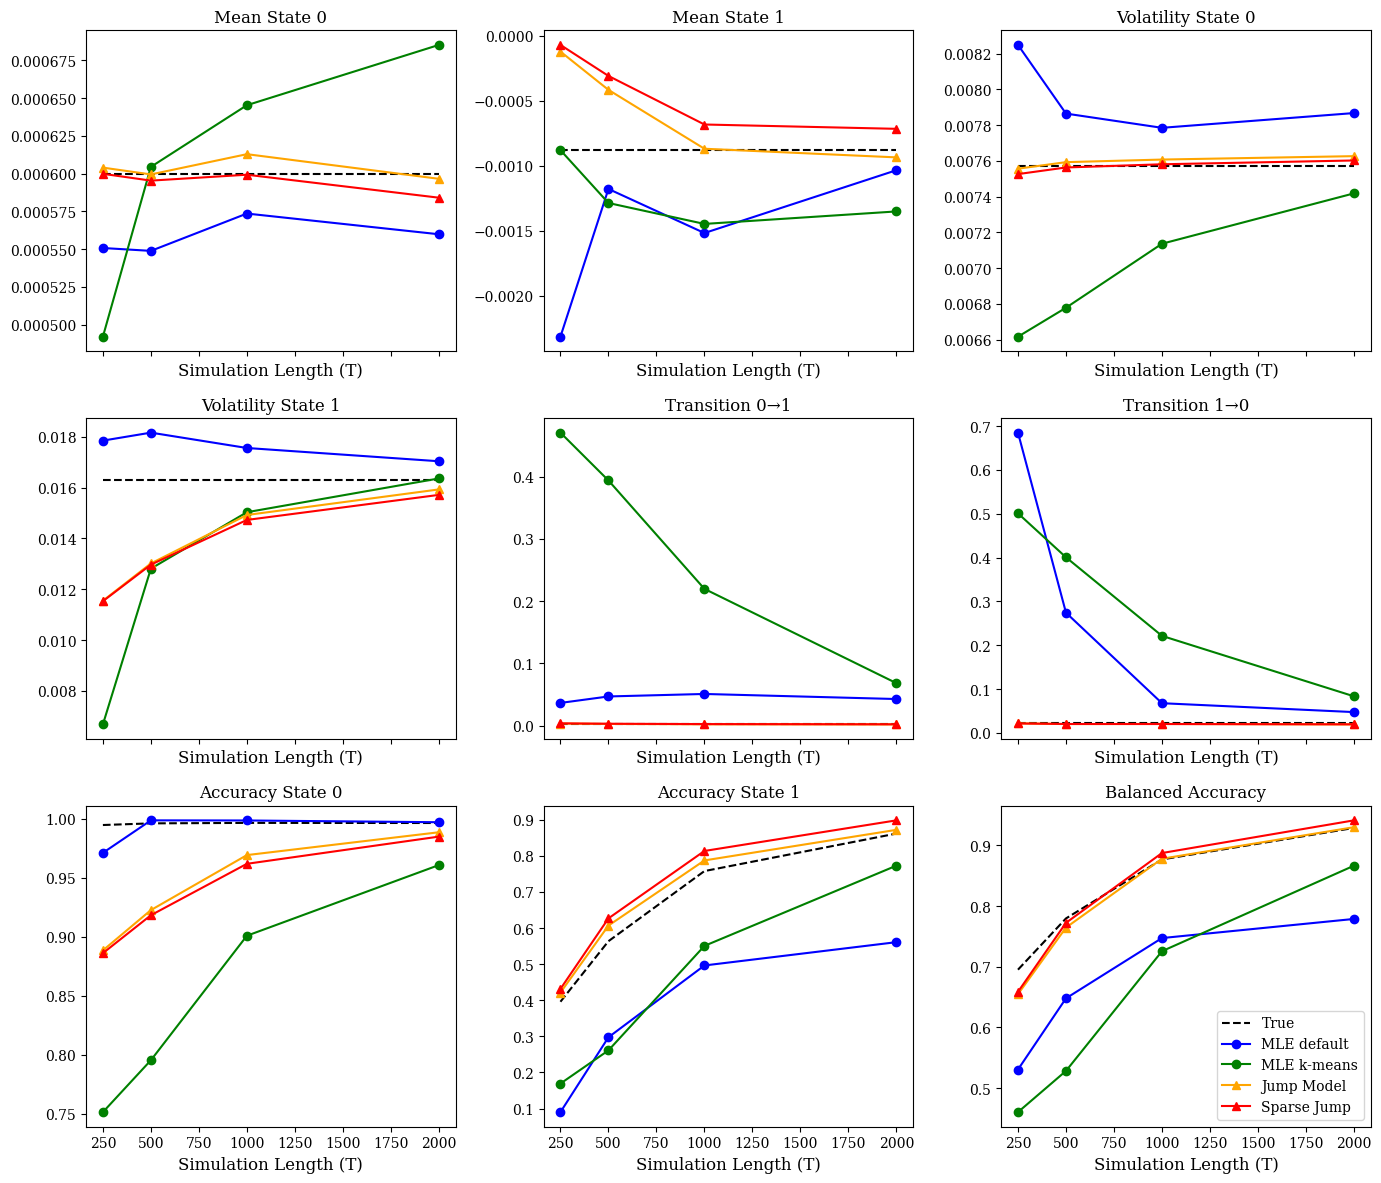

In [25]:
# -- 1) Build df_summary with T-specific True values --

# Fixed simulation parameters (same for all T)
TRUE_MU0     = 0.0006
TRUE_MU1     = -0.000881
TRUE_SIGMA0  = 0.00757
TRUE_SIGMA1  = 0.0163
TRUE_GAMMA12 = 0.0024
TRUE_GAMMA21 = 0.0232

# T-specific true decoding accuracies (previously computed)
true_acc_by_T = {
    250: {"acc1": 0.9945, "acc2": 0.3959, "BAC": 0.6952},
    500: {"acc1": 0.9959, "acc2": 0.5635, "BAC": 0.7797},
    1000: {"acc1": 0.9963, "acc2": 0.7577, "BAC": 0.8770},
    2000: {"acc1": 0.9962, "acc2": 0.8616, "BAC": 0.9289},
}

methods = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]
T_values = sorted(final_results["T"].unique())
rows = []

for T_val in T_values:
    df_T = final_results[final_results["T"] == T_val]
    # Use T-specific true accuracies along with fixed parameters.
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            "acc1":        true_acc_by_T[T_val]["acc1"],
            "acc2":        true_acc_by_T[T_val]["acc2"],
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE default": {
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12": df_T["MLE_gamma12"].mean(),
            "gamma21": df_T["MLE_gamma21"].mean(),
            "acc1": df_T["MLE_acc1"].mean(),
            "acc2": df_T["MLE_acc2"].mean(),
            "BAC": df_T["MLE_BAC"].mean()
        },
        "MLE k-means": {
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12": df_T["MLEK_gamma12"].mean(),
            "gamma21": df_T["MLEK_gamma21"].mean(),
            "acc1": df_T["MLEK_acc1"].mean(),
            "acc2": df_T["MLEK_acc2"].mean(),
            "BAC": df_T["MLEK_BAC"].mean()
        },
        "Jump Model": {
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12": df_T["Jump_gamma12"].mean(),
            "gamma21": df_T["Jump_gamma21"].mean(),
            "acc1": df_T["Jump_acc1"].mean(),
            "acc2": df_T["Jump_acc2"].mean(),
            "BAC": df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12": df_T["SparseJump_gamma12"].mean(),
            "gamma21": df_T["SparseJump_gamma21"].mean(),
            "acc1": df_T["SparseJump_acc1"].mean(),
            "acc2": df_T["SparseJump_acc2"].mean(),
            "BAC": df_T["SparseJump_BAC"].mean()
        }
    }
    
    for method_name, metrics in summary_dict.items():
        row = {"T": T_val, "Method": method_name}
        row.update(metrics)
        rows.append(row)

df_summary = pd.DataFrame(rows).round(7)

# -- 2) Plot in a 3×3 grid with custom line/marker styles --

# Define styles for each method:
method_styles = {
    "True":         {"linestyle": "--", "marker": None, "color": "black"},
    "MLE default":  {"linestyle": "-",  "marker": "o",  "color": "blue"},
    "MLE k-means":  {"linestyle": "-",  "marker": "o",  "color": "green"},
    "Jump Model":   {"linestyle": "-",  "marker": "^",  "color": "orange"},
    "Sparse Jump":  {"linestyle": "-",  "marker": "^",  "color": "red"}
}

# List of parameters to plot with pretty labels:
param_list = [
    ("state0_mean", "Mean State 0"),
    ("state1_mean", "Mean State 1"),
    ("state0_vol",  "Volatility State 0"),
    ("state1_vol",  "Volatility State 1"),
    ("gamma12",     "Transition 0→1"),
    ("gamma21",     "Transition 1→0"),
    ("acc1",        "Accuracy State 0"),
    ("acc2",        "Accuracy State 1"),
    ("BAC",         "Balanced Accuracy")
]

fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
axs = axs.ravel()

# Plot each parameter in its own subplot.
for i, (col, title) in enumerate(param_list):
    ax = axs[i]
    for method in methods:
        sub_df = df_summary[df_summary["Method"] == method]
        y_vals = []
        for tval in T_values:
            row = sub_df[sub_df["T"] == tval]
            if len(row) == 1:
                y_vals.append(row[col].values[0])
            else:
                y_vals.append(np.nan)
        style = method_styles[method]
        ax.plot(T_values, y_vals,
                linestyle=style["linestyle"],
                marker=style["marker"],
                color=style["color"],
                label=method)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Simulation Length (T)")
    ax.grid(False)

# Add legend to the last subplot
axs[-1].legend(loc="best", fontsize=10)

plt.tight_layout()
plt.show()


### 6.0 Simulation of choosing the right values of lambda

#### 6.1 Jump model lambda simulation

In [29]:
#This is the section we will use to simulate lambda values for the jump model and sparse jump model with presed k=9
# We will:
# 1. Vary \(\lambda\) over a range of values on a log scale (e.g. \(10^{-2}\) to \(10^{4}\)).  
# 2. For each simulation length \(T\in\{250,500,1000,2000\}\) and each \(\lambda\) value, we will:
#    - Simulate data using `simulate_data(...)`.
#    - Transform the data into features with `combine_features(...)`.
#    - Fit the Jump Model using `run_jump_model(...)`.
#    - Compute the Balanced Accuracy (BAC).
#    - Repeat multiple times (e.g. 30 seeds) and average.
# 3. Plot the resulting average BAC vs. \(\lambda\) (log-scale) for each \(T\).
# 
# This replicates the style of **Figure&nbsp;2** in Nystrup et al. (2020b), showing how the penalty parameter influences performance at different simulation lengths.

# %%
def simulate_for_lambda(T_val, lam, n_simulations):
    """
    For a given sample length T_val and penalty parameter lam,
    simulate n_simulations runs and return the average BAC.
    """
    bac_list = []
    for seed in range(n_simulations):
        # 1) Simulate data
        y, true_states = simulate_data(T_val, random_state=seed)
        
        # 2) Build features and standardize (as in run_one_simulation)
        Z = combine_features(y, l_list=[5, 13])
        Z_df = pd.DataFrame(Z)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        Z_clipped = clipper.fit_transform(Z_df)
        Z_scaled = scaler.fit_transform(Z_clipped)
        Z_scaled_arr = Z_scaled.values

        # 3) Fit Jump Model with the current lambda value
        pred_jump = run_jump_model(Z_scaled_arr, n_components=2, lambda_=lam, random_state=seed)

        # 4) Compute Balanced Accuracy (BAC)
        _, _, bac_val = compute_per_state_accuracy(true_states, pred_jump)
        bac_list.append(bac_val)
        
    mean_bac = np.mean(bac_list)
    return {"T": T_val, "lambda": lam, "BAC": mean_bac}

# Define the lambda grid and T values
lambda_grid = np.logspace(-2, 2.5, 10)  # for example: 10 values from 1e-2 to 1e4
T_values_lam = [250, 500, 1000, 2000]
n_simulations_lam = 30

# Use joblib.Parallel to run the simulations in parallel
results_lam = Parallel(n_jobs=-1)(
    delayed(simulate_for_lambda)(T_val, lam, n_simulations_lam)
    for T_val in T_values_lam
    for lam in lambda_grid
)

# Convert the results to a DataFrame for plotting
df_lambda = pd.DataFrame(results_lam)


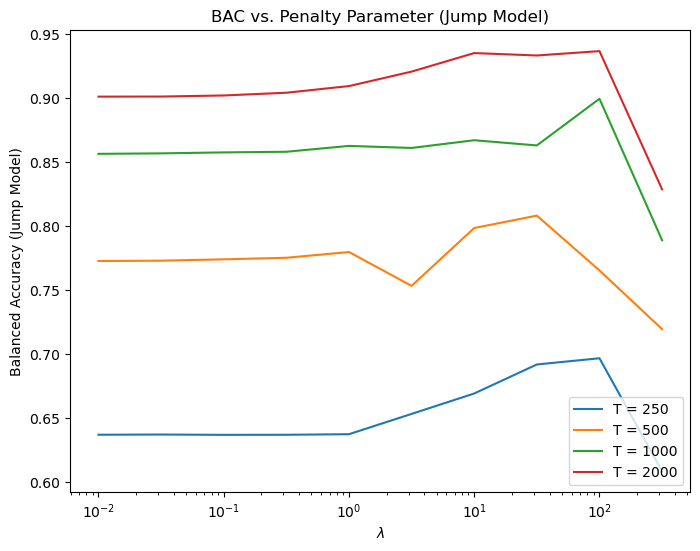

In [30]:
# Plot: BAC vs. lambda (with lambda on a log-scale) for each T
plt.figure(figsize=(8, 6))
for T_val in T_values_lam:
    sub_df = df_lambda[df_lambda["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  # ensure ascending order of lambda
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Jump Model)")
plt.title("BAC vs. Penalty Parameter (Jump Model)")
plt.legend()
plt.show()

#### 6.2 Sparse Jump (kappa^2=15) lambda simulatino


In [31]:
# This section is similar to the previous Jump Model penalty sweep, but now for the **SparseJumpModel**. 
# We'll:
# 1. Vary \(\lambda\) over a log scale (e.g. \(10^{-2}\) to \(10^{4}\)).
# 2. For each simulation length \(T\in\{250,500,1000,2000\}\) and each \(\lambda\) value, we:
#    - Simulate data (with `simulate_data`).
#    - Build & standardize features (with `combine_features` + `DataClipperStd` + `StandardScalerPD`).
#    - Fit **SparseJumpModel** using `run_sparse_jump_model(..., max_feats=15)`.
#    - Compute Balanced Accuracy (BAC).
#    - Repeat multiple seeds and average.
# 3. Plot average BAC vs. \(\lambda\) (log-scale) for each \(T\), mirroring Figure&nbsp;2 style from the paper.

def simulate_for_lambda_sjump(T_val, lam, n_simulations):
    """
    For a given sample length T_val and penalty parameter lam, simulate n_simulations runs using the SparseJumpModel
    (with max_feats=15) and return the average Balanced Accuracy (BAC).
    """
    bac_list = []
    for seed in range(n_simulations):
        # 1) Simulate data
        y, true_states = simulate_data(T_val, random_state=seed)

        # 2) Build and standardize features
        Z = combine_features(y, l_list=[5, 13])
        Z_df = pd.DataFrame(Z)
        clipper = DataClipperStd(mul=3.0)
        scaler = StandardScalerPD()
        Z_clipped = clipper.fit_transform(Z_df)
        Z_scaled = scaler.fit_transform(Z_clipped)
        Z_scaled_arr = Z_scaled.values

        # 3) Fit SparseJumpModel with current lambda and max_feats=15
        pred_sjump = run_sparse_jump_model(
            Z_scaled_arr, 
            n_components=2, 
            lambda_=lam, 
            max_feats=15, 
            random_state=seed
        )

        # 4) Compute Balanced Accuracy (BAC)
        _, _, bac_val = compute_per_state_accuracy(true_states, pred_sjump)
        bac_list.append(bac_val)
        
    mean_bac = np.mean(bac_list)
    return {"T": T_val, "lambda": lam, "BAC": mean_bac}

# Define the lambda grid, simulation lengths, and number of simulations (seeds)
lambda_grid_sjump = np.logspace(-2, 2.5, 10)  # 7 values from 1e-2 to 1e4
T_values_sjump = [250, 500, 1000, 2000]
n_simulations_sjump = 1000

# Run the simulations in parallel over all combinations of T and lambda
results_sjump = Parallel(n_jobs=-1)(
    delayed(simulate_for_lambda_sjump)(T_val, lam, n_simulations_sjump)
    for T_val in T_values_sjump
    for lam in lambda_grid_sjump
)

# Convert results to a DataFrame for plotting
df_sjump = pd.DataFrame(results_sjump)

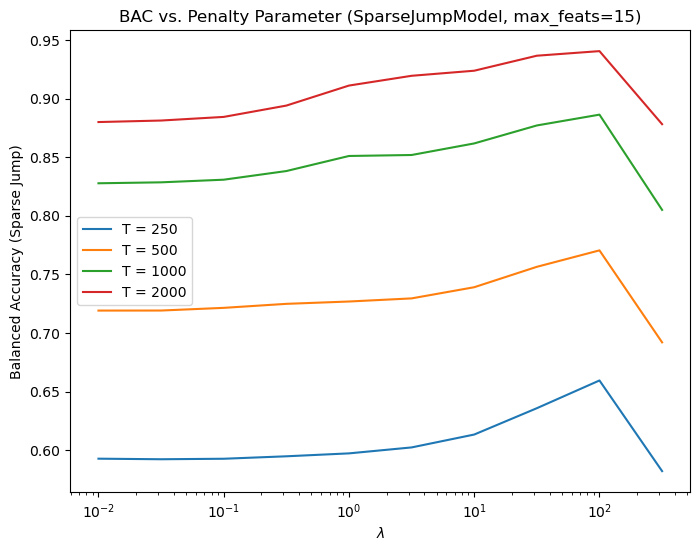

In [32]:
# ---- Plot: BAC vs. lambda for each T ----
plt.figure(figsize=(8, 6))
for T_val in T_values_sjump:
    sub_df = df_sjump[df_sjump["T"] == T_val].copy()
    sub_df.sort_values("lambda", inplace=True)  # ensure ascending order of lambda
    plt.plot(sub_df["lambda"], sub_df["BAC"], marker="", label=f"T = {T_val}")

plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Balanced Accuracy (Sparse Jump)")
plt.title("BAC vs. Penalty Parameter (SparseJumpModel, max_feats=15)")
plt.legend()
plt.show()

In [34]:
import os

# --- Create output folder ---
output_dir = r"/Users/vlad/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Documents - Master's Thesis/Outputs_python"
os.makedirs(output_dir, exist_ok=True)

# --- Save all open figures ---
# This loop saves every open figure with a unique filename.
for i in plt.get_fignums():
    plt.figure(i)
    fig_filename = os.path.join(output_dir, f"figure_{i}.png")
    plt.savefig(fig_filename)
    print(f"Saved figure {i} to {fig_filename}")

# --- Save result tables (DataFrames) ---
# Assuming your key DataFrames are named final_results, df_lambda, df_sjump, and df_summary:
final_results.to_csv(os.path.join(output_dir, "gfinal_results.csv"), index=False)
df_lambda.to_csv(os.path.join(output_dir, "gdf_lambda.csv"), index=False)
df_sjump.to_csv(os.path.join(output_dir, "gdf_sjump.csv"), index=False)
df_summary.to_csv(os.path.join(output_dir, "gdf_summary.csv"), index=False)
wilcoxon_table_T.to_csv(os.path.join(output_dir, "gwilcoxon_table_T.csv"), index=False)

print("All figures and tables have been saved.")


PermissionError: [WinError 5] Access is denied: '/Users/vlad'

In [147]:
import os

# Set output directory to the current working directory (the notebook's location)
output_dir = os.getcwd()

# Save all open figures
for i in plt.get_fignums():
    plt.figure(i)
    fig_filename = os.path.join(output_dir, f"figure_{i}.png")
    plt.savefig(fig_filename)
    print(f"Saved figure {i} to {fig_filename}")

# Save result tables (DataFrames)
final_results.to_csv(os.path.join(output_dir, "gfinal_results.csv"), index=False)
df_lambda.to_csv(os.path.join(output_dir, "gdf_lambda.csv"), index=False)
df_sjump.to_csv(os.path.join(output_dir, "gdf_sjump.csv"), index=False)
df_summary.to_csv(os.path.join(output_dir, "gdf_summary.csv"), index=False)
wilcoxon_table_T.to_csv(os.path.join(output_dir, "gwilcoxon_table_T.csv"), index=False)

print("All figures and tables have been saved.")

All figures and tables have been saved.


#### Illustrations Part 2

#### Line graphs for tracking parameters

In [26]:
final_results = pd.read_csv("gfinal_results.csv")
T_values = [250, 500, 1000, 2000]

# ----- T-specific True decoding accuracies (hard-coded) -----
true_acc_by_T = {
    250: {"acc0": 0.9945, "acc1": 0.3959, "BAC": 0.6952},
    500: {"acc0": 0.9959, "acc1": 0.5635, "BAC": 0.7797},
    1000: {"acc0": 0.9963, "acc1": 0.7577, "BAC": 0.8770},
    2000: {"acc0": 0.9962, "acc1": 0.8616, "BAC": 0.9289},
}

# Update the df_summary block to use the new method names
for T_val in sorted(T_values):
    df_T = final_results[final_results["T"] == T_val]
    
    summary_dict = {
        "True": {
            "state0_mean": TRUE_MU0,
            "state1_mean": TRUE_MU1,
            "state0_vol":  TRUE_SIGMA0,
            "state1_vol":  TRUE_SIGMA1,
            "gamma12":     TRUE_GAMMA12,
            "gamma21":     TRUE_GAMMA21,
            # Use the correct keys from true_acc_by_T:
            "acc1":        true_acc_by_T[T_val]["acc1"],
            "acc2":        true_acc_by_T[T_val]["acc2"],
            "BAC":         true_acc_by_T[T_val]["BAC"]
        },
        "MLE": {  # formerly "MLE default"
            "state0_mean": df_T["MLE_state0_mean"].mean(),
            "state1_mean": df_T["MLE_state1_mean"].mean(),
            "state0_vol":  df_T["MLE_state0_vol"].mean(),
            "state1_vol":  df_T["MLE_state1_vol"].mean(),
            "gamma12":     df_T["MLE_gamma12"].mean(),
            "gamma21":     df_T["MLE_gamma21"].mean(),
            "acc1":        df_T["MLE_acc1"].mean(),
            "acc2":        df_T["MLE_acc2"].mean(),
            "BAC":         df_T["MLE_BAC"].mean()
        },
        "MLE_k": {  # formerly "MLE k-means"
            "state0_mean": df_T["MLEK_state0_mean"].mean(),
            "state1_mean": df_T["MLEK_state1_mean"].mean(),
            "state0_vol":  df_T["MLEK_state0_vol"].mean(),
            "state1_vol":  df_T["MLEK_state1_vol"].mean(),
            "gamma12":     df_T["MLEK_gamma12"].mean(),
            "gamma21":     df_T["MLEK_gamma21"].mean(),
            "acc1":        df_T["MLEK_acc1"].mean(),
            "acc2":        df_T["MLEK_acc2"].mean(),
            "BAC":         df_T["MLEK_BAC"].mean()
        },
        "Jump": {  # formerly "Jump Model"
            "state0_mean": df_T["Jump_state0_mean"].mean(),
            "state1_mean": df_T["Jump_state1_mean"].mean(),
            "state0_vol":  df_T["Jump_state0_vol"].mean(),
            "state1_vol":  df_T["Jump_state1_vol"].mean(),
            "gamma12":     df_T["Jump_gamma12"].mean(),
            "gamma21":     df_T["Jump_gamma21"].mean(),
            "acc1":        df_T["Jump_acc1"].mean(),
            "acc2":        df_T["Jump_acc2"].mean(),
            "BAC":         df_T["Jump_BAC"].mean()
        },
        "Sparse Jump": {
            "state0_mean": df_T["SparseJump_state0_mean"].mean(),
            "state1_mean": df_T["SparseJump_state1_mean"].mean(),
            "state0_vol":  df_T["SparseJump_state0_vol"].mean(),
            "state1_vol":  df_T["SparseJump_state1_vol"].mean(),
            "gamma12":     df_T["SparseJump_gamma12"].mean(),
            "gamma21":     df_T["SparseJump_gamma21"].mean(),
            "acc1":        df_T["SparseJump_acc1"].mean(),
            "acc2":        df_T["SparseJump_acc2"].mean(),
            "BAC":         df_T["SparseJump_BAC"].mean()
        }
    }
    
    summary_df = pd.DataFrame(summary_dict).T
    col_order = [
        "state0_mean", "state1_mean",
        "state0_vol",  "state1_vol",
        "gamma12",     "gamma21",
        "acc0",        "acc1", 
        "BAC"
    ]
    summary_df = summary_df[col_order]
    
    print(f"\nSummary for T = {T_val}")
    print(summary_df)

KeyError: 'acc2'

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

# Update rcParams for larger, journal‐style plots with LaTeX formatting.
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

def plot_parameter(
    df, 
    param_col,
    param_label,
    log_y=False,
    methods=("True", "MLE", "MLE_k", "Jump", "Sparse Jump"),
    scale_factor=1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=None  # New optional parameter for custom legend names
):
    """
    Plots `param_col` (after applying a scale_factor) versus simulation length T for each method.
    
    Args:
        df (pd.DataFrame): DataFrame with columns "T", "Method", and `param_col`.
        param_col (str): Column name in df to plot.
        param_label (str): Base y-axis label (e.g. r"$\mu_1$").
        log_y (bool): Whether to use a logarithmic scale on the y-axis.
        methods (tuple): The order of methods to plot.
        scale_factor (float): Multiply the raw values by this factor before plotting.
        preset_y_limits (tuple or None): Optional y-axis limits (ymin, ymax) after scaling.
        figsize (tuple): Figure size.
        legend_labels (dict or None): Dictionary for renaming legend entries (e.g.,
            {"True": "Ground Truth", "MLE": "MLE Model", ...}). If None, original names are used.
    """
    plt.figure(figsize=figsize)
    
    # Define method-specific styles with updated names.
    method_styles = {
        "True":         {"color": "black", "linestyle": ":",  "marker": None, "linewidth": 1.5},
        "MLE default":  {"color": "blue",  "linestyle": "-",   "marker": "o",  "linewidth": 1.5},
        "MLE k-means":  {"color": "green", "linestyle": "-",   "marker": "s",  "linewidth": 1.5},
        "Jump Model":   {"color": "orange","linestyle": "-",   "marker": "^",  "linewidth": 1.5},
        "Sparse Jump":  {"color": "red",   "linestyle": "-",   "marker": "d",  "linewidth": 1.5}
    }
    
    # Get sorted simulation lengths (T values); expected to be [250, 500, 1000, 2000]
    T_values = sorted(df["T"].unique())
    
    # Collect all scaled y-values for dynamic y-limit calculation (if not preset)
    all_scaled = []
    
    for method in methods:
        sub_df = df[df["Method"] == method].copy()
        sub_df.sort_values(by="T", inplace=True)
        
        xvals, yvals = [], []
        for t in T_values:
            row = sub_df[sub_df["T"] == t]
            xvals.append(t)
            # If there's a value, scale it; otherwise, assign nan.
            raw_val = row[param_col].iloc[0] if len(row) == 1 else np.nan
            scaled_val = raw_val * scale_factor if not pd.isna(raw_val) else np.nan
            yvals.append(scaled_val)
        all_scaled.extend([val for val in yvals if not pd.isna(val)])
        
        style = method_styles.get(method, {"color": "black", "linestyle": "-", "marker": "o", "linewidth": 1.5})
        
        # Use custom legend name if provided; otherwise use method.
        label = legend_labels.get(method, method) if legend_labels is not None else method
        
        plt.plot(
            xvals, 
            yvals, 
            label=label, 
            color=style["color"],
            linestyle=style["linestyle"],
            marker=style["marker"],
            linewidth=style["linewidth"],
            markersize=4 if style["marker"] is not None else None
        )
    
    # Set the x-axis ticks explicitly.
    plt.xticks([250, 500, 1000, 2000])
    plt.xlabel(r"Simulation length $T$")
    
    # Append the multiplicative factor to the y-axis label if scaling is applied.
    if scale_factor != 1:
        exponent = int(np.log10(scale_factor))
        factor_label = r"$\,\times\,10^{-" + f"{abs(exponent)}" + "}$"
    else:
        factor_label = ""
    plt.ylabel(param_label + factor_label)
    
    if log_y:
        plt.yscale('log')
    
    # Set y-limits: use preset or calculate a margin.
    if preset_y_limits is not None:
        plt.ylim(preset_y_limits)
    elif all_scaled:
        y_min, y_max = min(all_scaled), max(all_scaled)
        margin = 0.1 * (y_max - y_min) if (y_max - y_min) != 0 else 1e-6
        plt.ylim(y_min - margin, y_max + margin)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vri\AppData\Local\Temp\ipykernel_14604\1353413324.py:29: SyntaxWarning: invalid escape sequence '\m'
  """


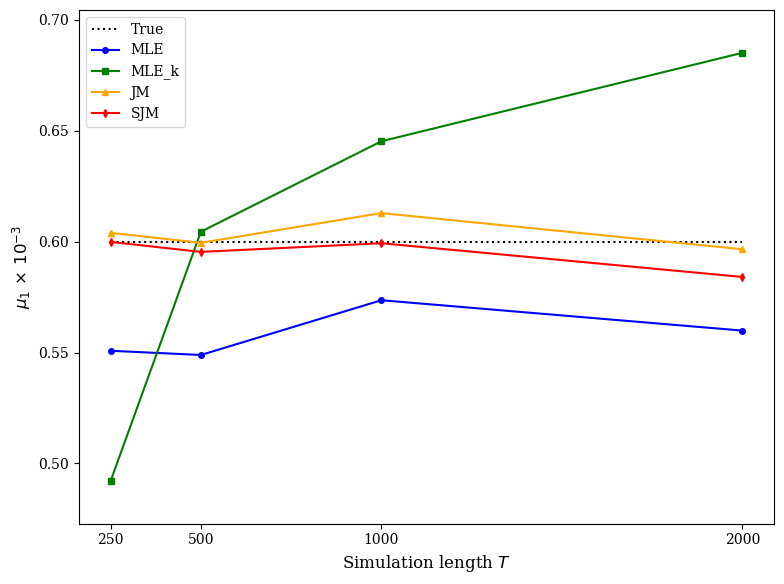

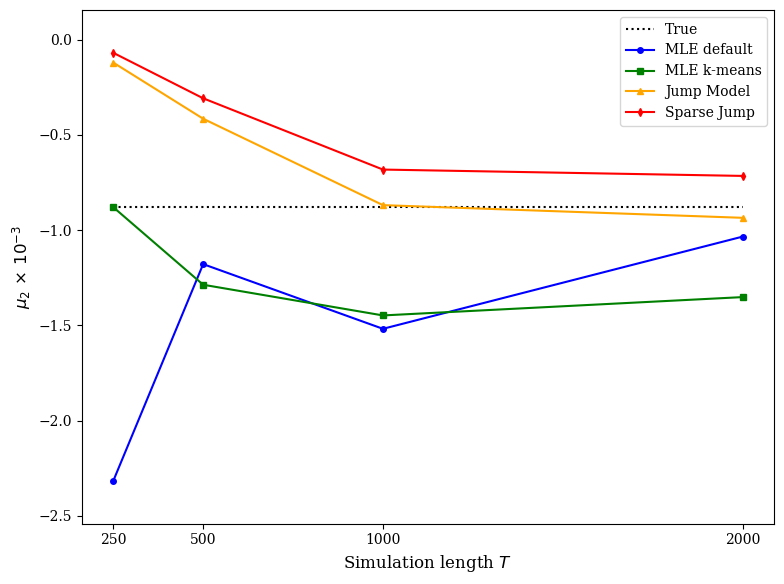

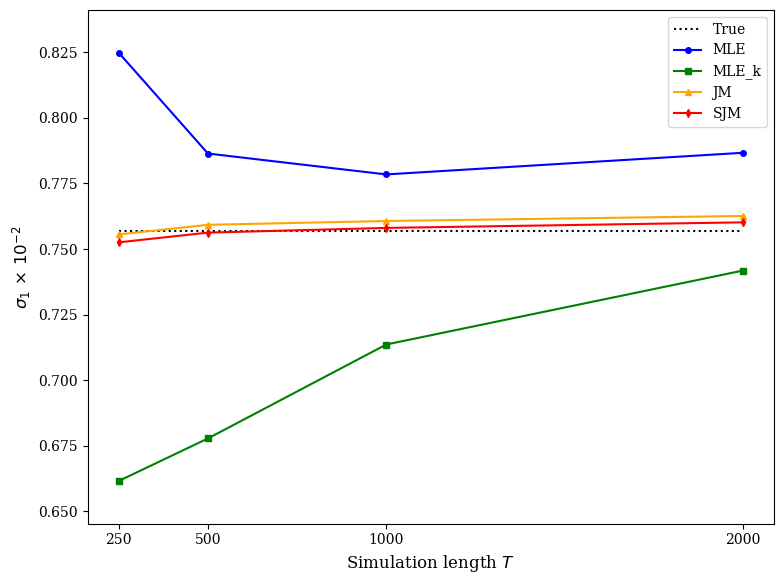

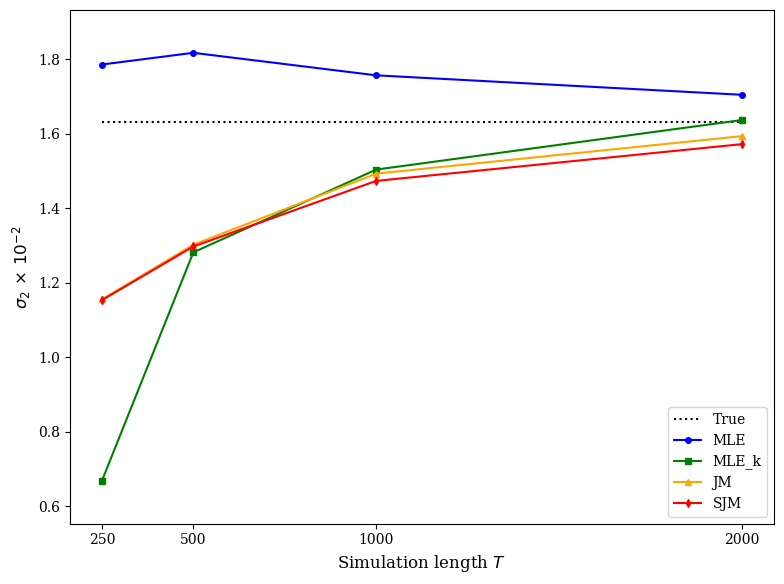

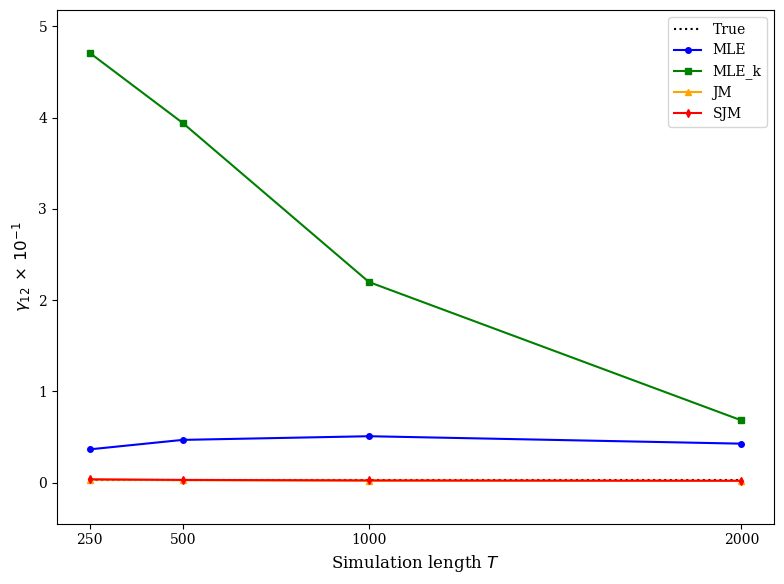

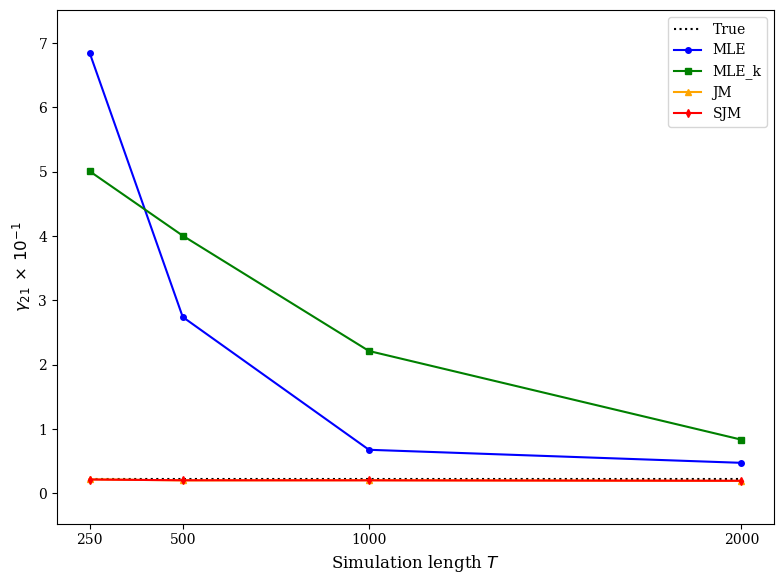

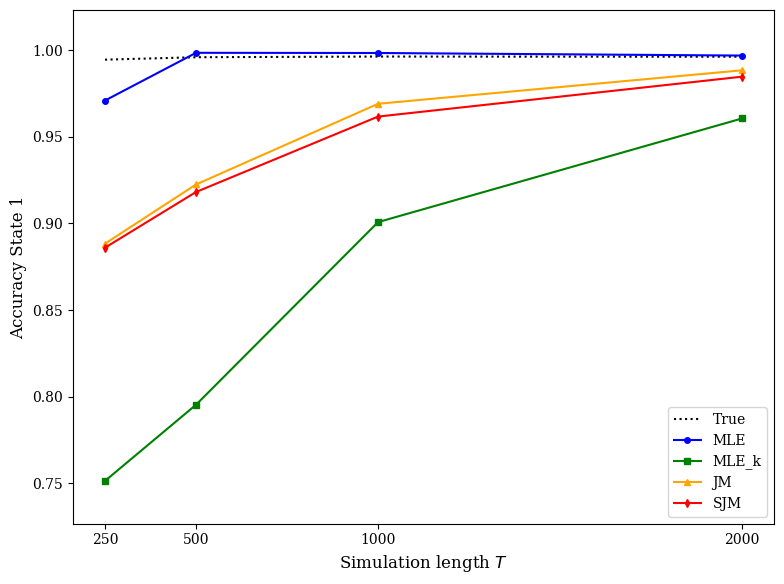

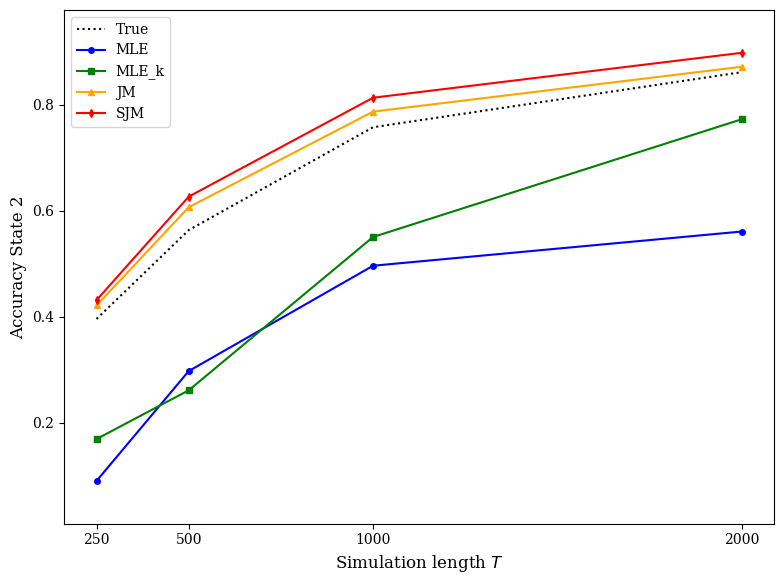

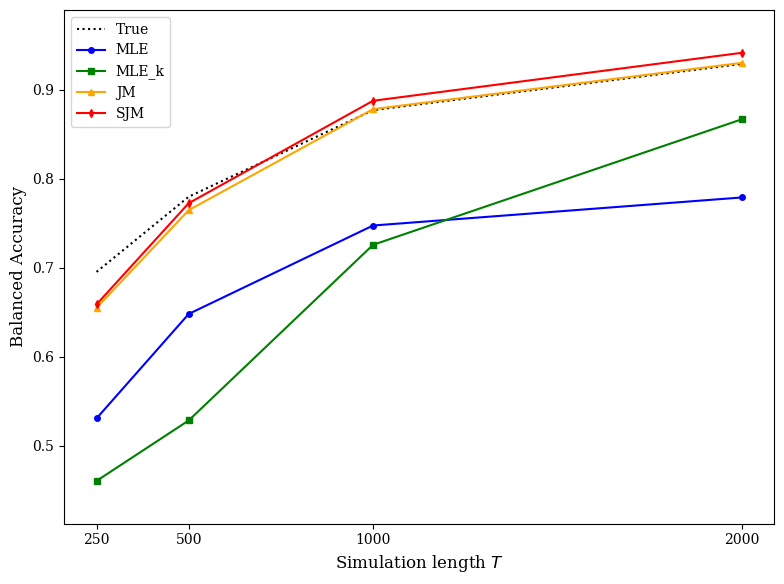

In [28]:
custom_legend = {
    "True": "True",
    "MLE default": "MLE",
    "MLE k-means": "MLE_k",
    "Jump Model": "JM",
    "Sparse Jump": "SJM"
}

#Plotting all parameters across models
methods_to_plot = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]

# 1. Plot for μ₁ (state0_mean)
plot_parameter(
    df=df_summary,
    param_col="state0_mean",
    param_label=r"$\mu_1$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e3,           # Example: scales values ~6e-4 to ~6.0
    preset_y_limits=None,       # Set as desired
    figsize=(8,6),
    legend_labels=custom_legend  # Use custom legend labels
)

# 2. Plot for μ₂ (state1_mean)
plot_parameter(
    df=df_summary,
    param_col="state1_mean",
    param_label=r"$\mu_2$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e3,
    preset_y_limits=None,
    figsize=(8,6)
)

# 3. Plot for σ₁ (state0_vol)
plot_parameter(
    df=df_summary,
    param_col="state0_vol",
    param_label=r"$\sigma_1$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e2,           # Adjust if values are around 0.0075 → ~0.75
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

# 4. Plot for σ₂ (state1_vol)
plot_parameter(
    df=df_summary,
    param_col="state1_vol",
    param_label=r"$\sigma_2$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e2,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)


# 5. Plot for Transition Probability γ₁₂ (gamma12)
# For example, if values around 0.0021, you might set scale_factor=1e3 to visualize them as ~2.1.
plot_parameter(
    df=df_summary,
    param_col="gamma12",
    param_label=r"$\gamma_{12}$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

# 6. Plot for Transition Probability γ₂₁ (gamma21)
# For example, if values around 0.012, scale_factor=1e3 shows ~12.
plot_parameter(
    df=df_summary,
    param_col="gamma21",
    param_label=r"$\gamma_{21}$",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1e1,
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

# 7. Plot for Accuracy State 0 (acc1)
plot_parameter(
    df=df_summary,
    param_col="acc1",
    param_label=r"Accuracy State 1",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,            # Adjust if scaling is needed
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

# 8. Plot for Accuracy State 1 (acc2)
plot_parameter(
    df=df_summary,
    param_col="acc2",
    param_label=r"Accuracy State 2",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,            # Adjust if scaling is needed
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)



# 9. Plot for Balanced Accuracy (BAC)
plot_parameter(
    df=df_summary,
    param_col="BAC",
    param_label=r"Balanced Accuracy",
    log_y=False,
    methods=methods_to_plot,
    scale_factor=1,             # No scaling
    preset_y_limits=None,
    figsize=(8,6),
    legend_labels=custom_legend
)

In [80]:
df_summary

,state0_mean,state1_mean,state0_vol,state1_vol,gamma12,gamma21,acc1,acc2,BAC
True,0.000600,-0.000881,0.007570,0.016300,0.002400,0.023200,0.996200,0.861600,0.928900
MLE default,0.000560,-0.001034,0.007867,0.017043,0.042585,0.047648,0.996863,0.560851,0.778857
MLE k-means,0.000685,-0.001351,0.007418,0.016365,0.068103,0.083638,0.960590,0.772741,0.866666
Jump Model,0.000597,-0.000935,0.007626,0.015933,0.001756,0.019539,0.988369,0.871880,0.930124
Sparse Jump,0.000584,-0.000715,0.007602,0.015718,0.001954,0.019762,0.984683,0.898157,0.941420


#### Box Plots For performance

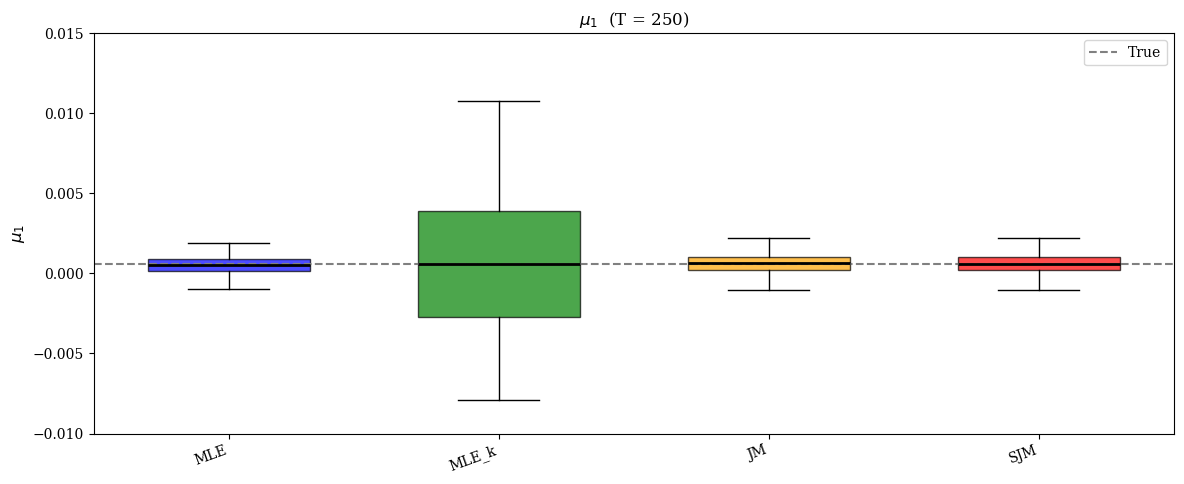

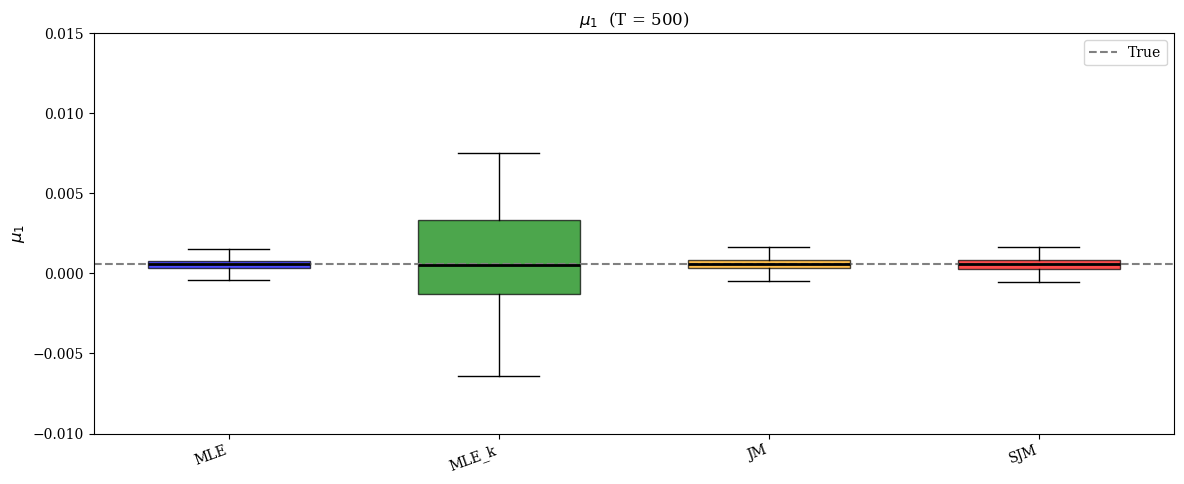

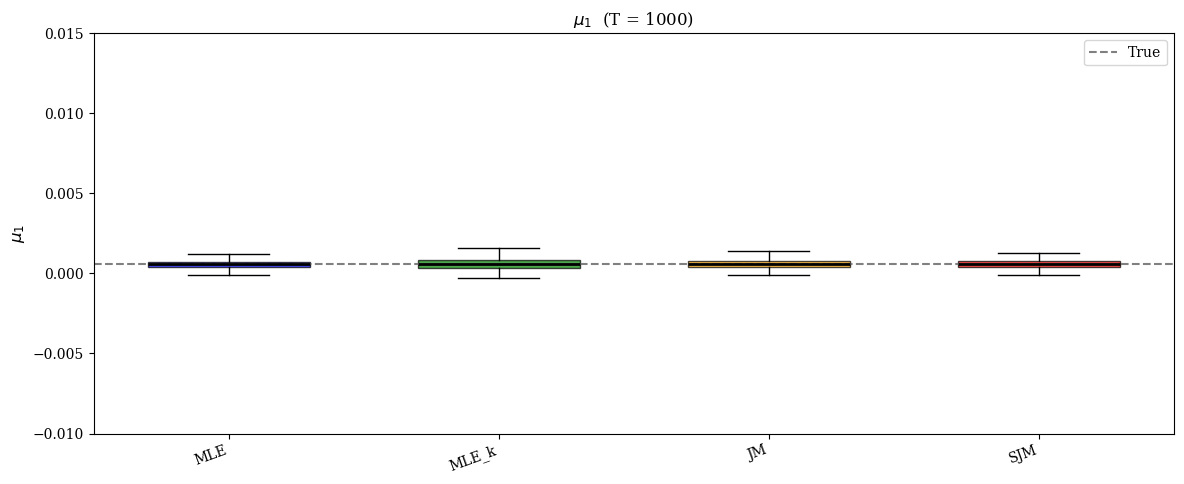

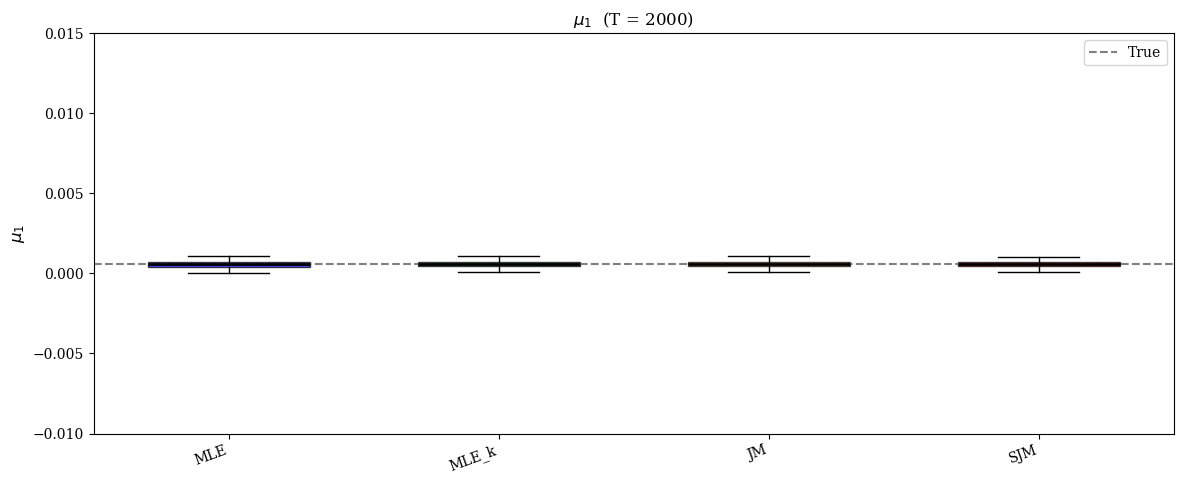

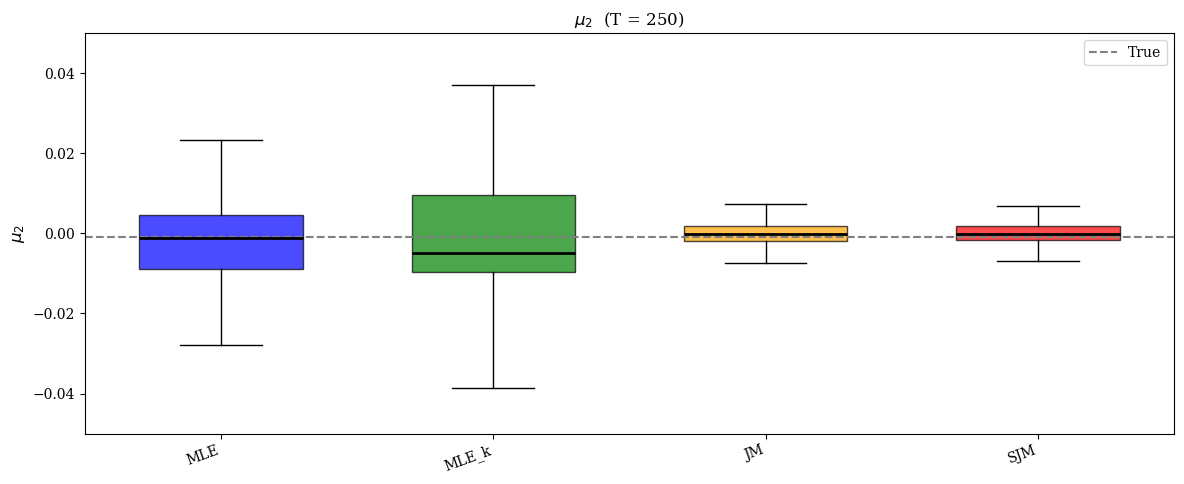

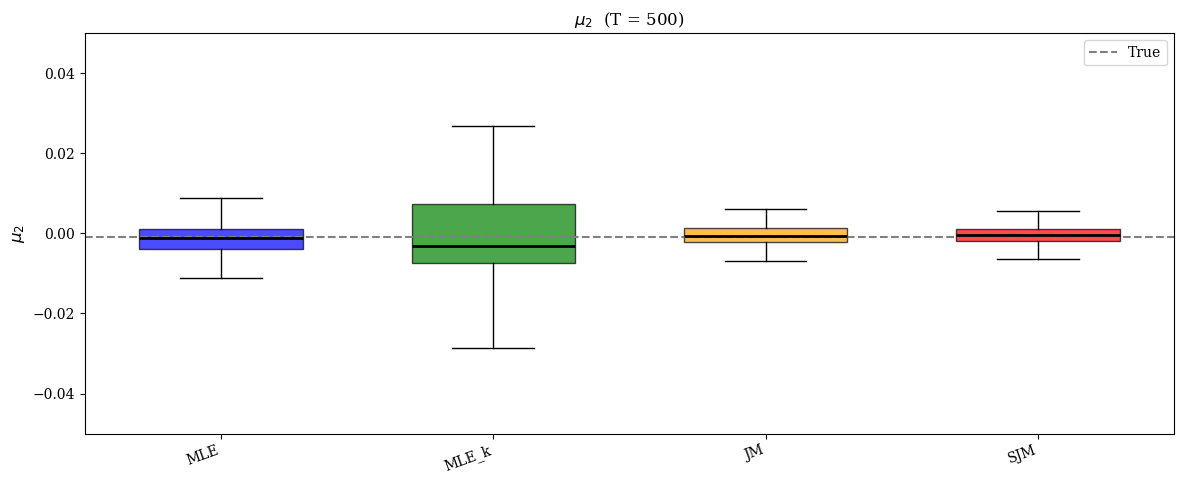

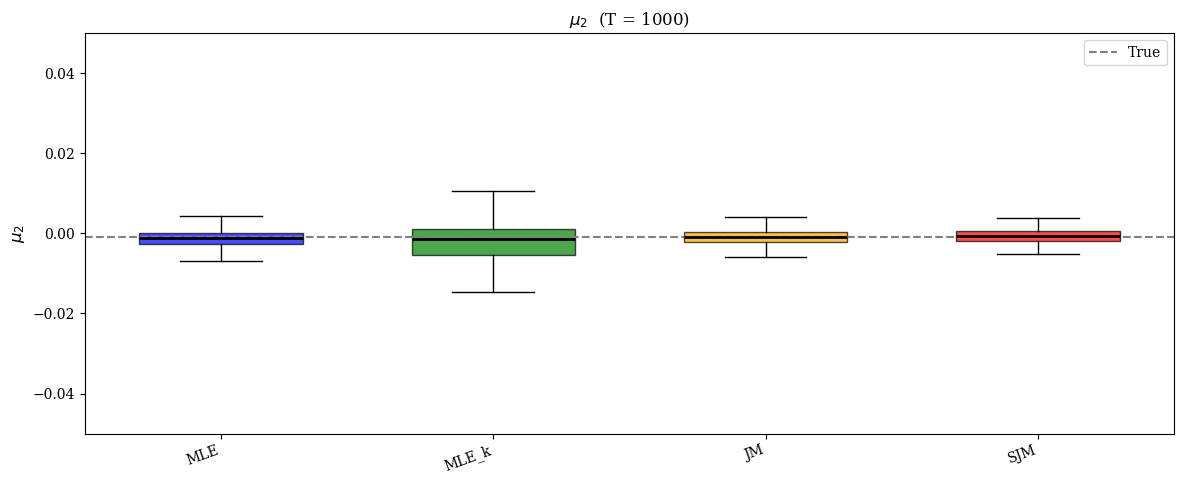

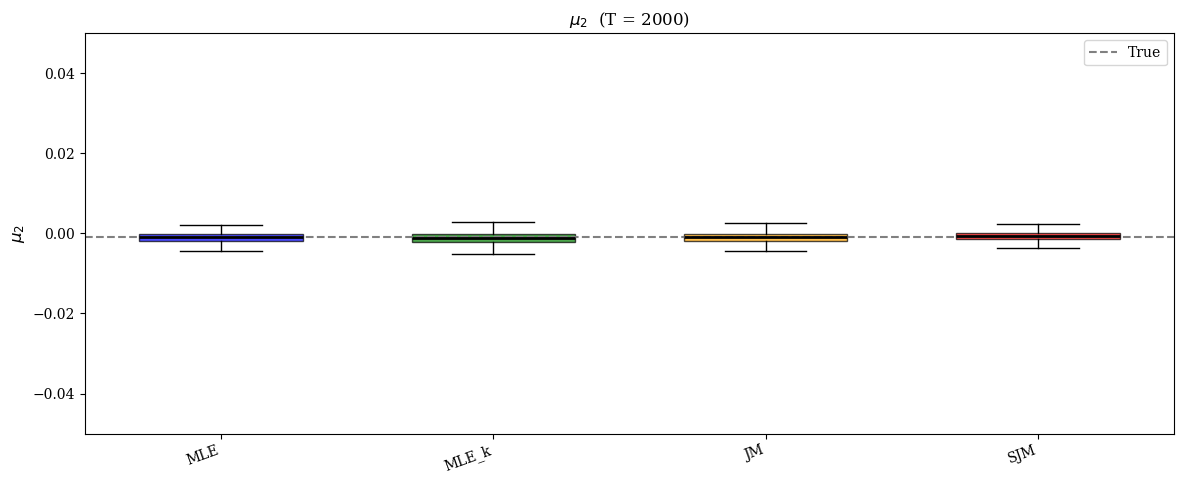

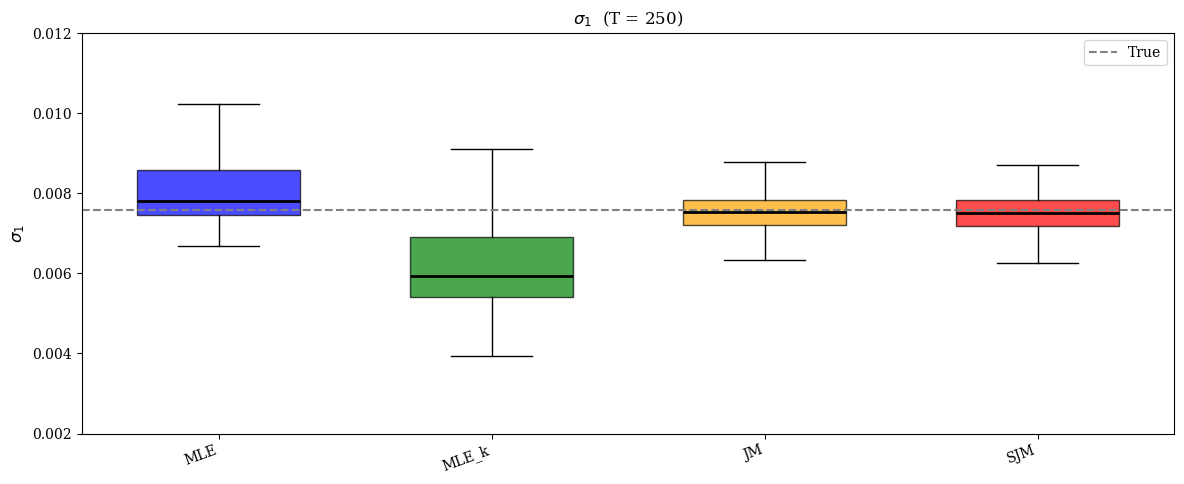

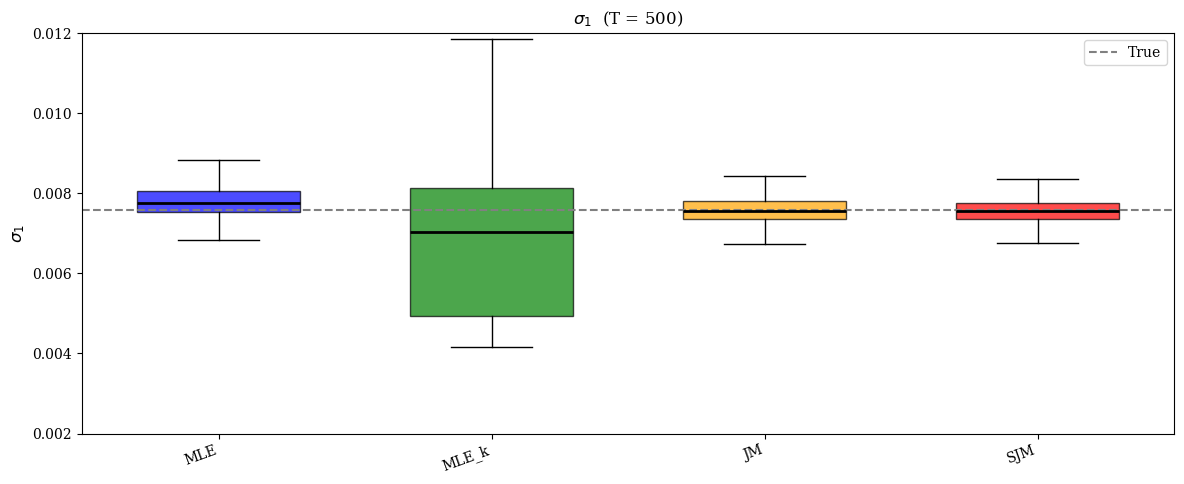

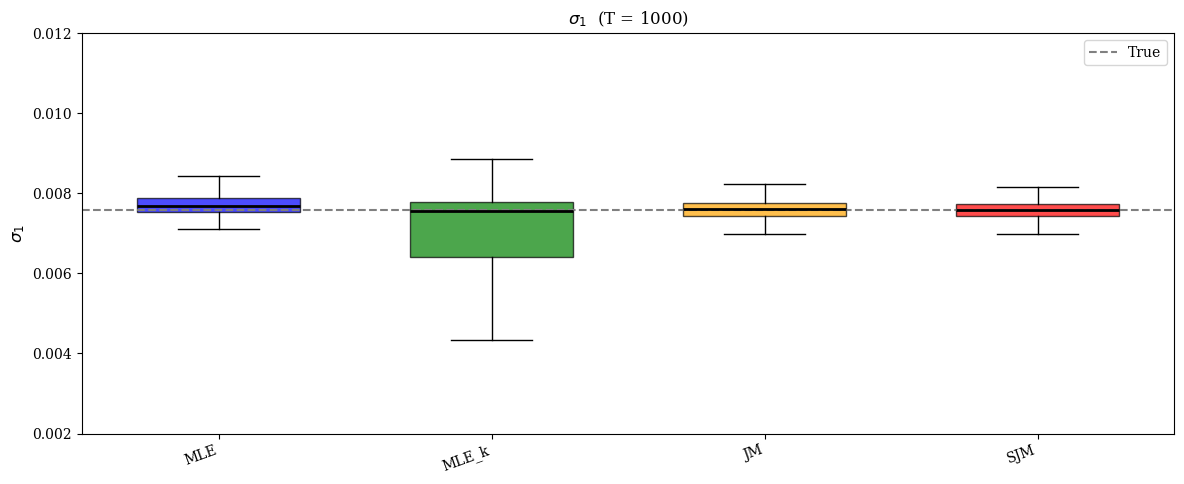

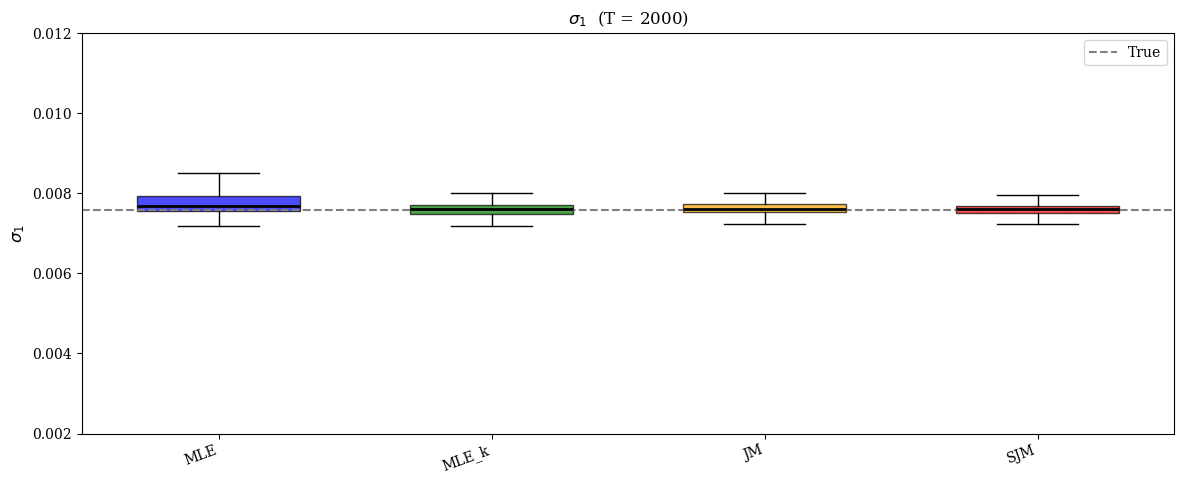

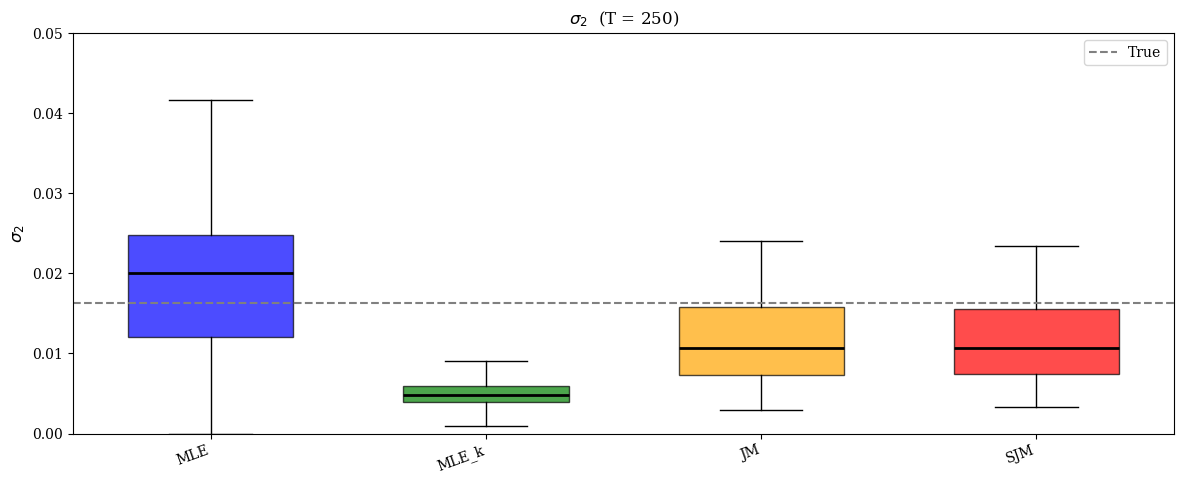

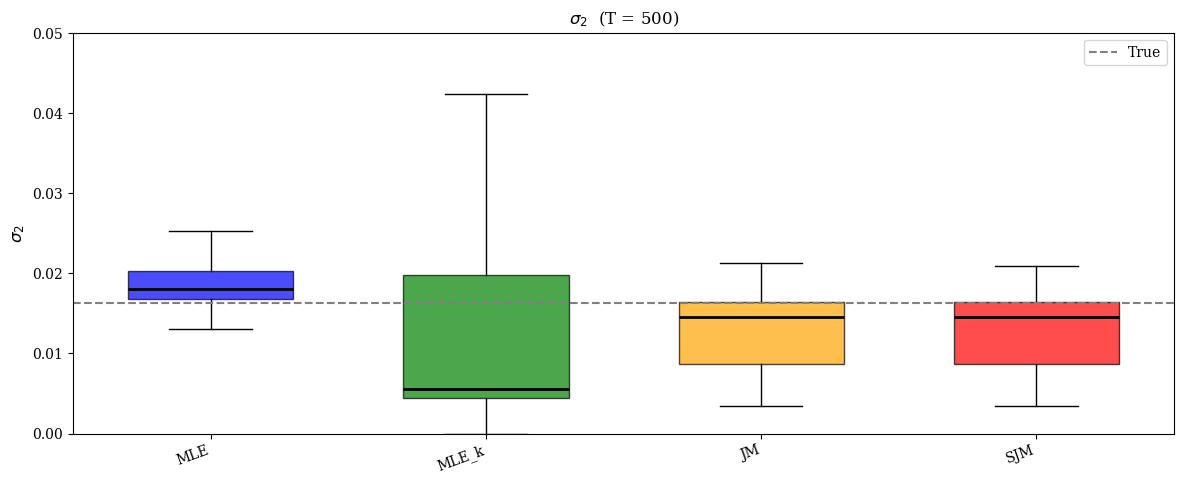

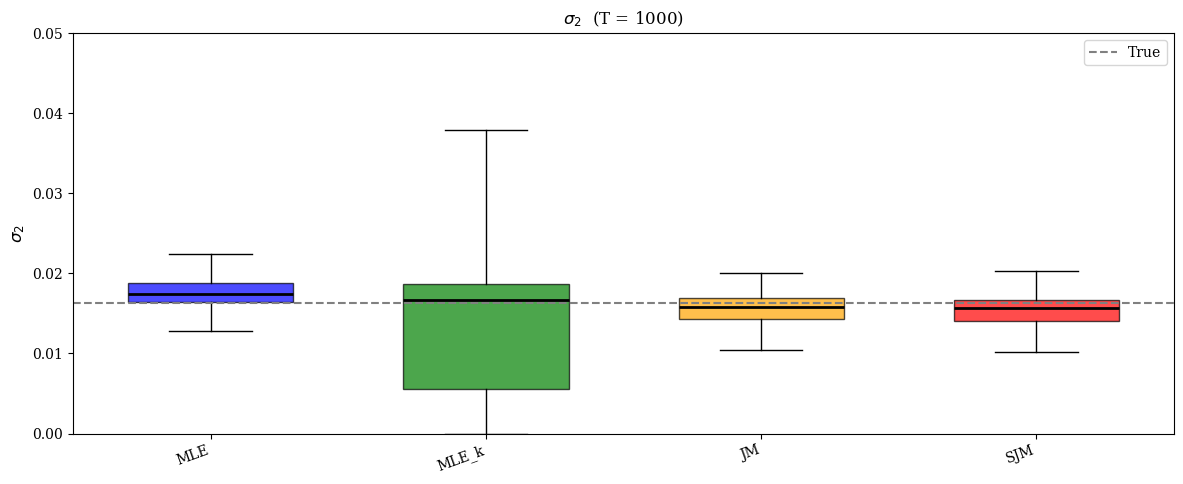

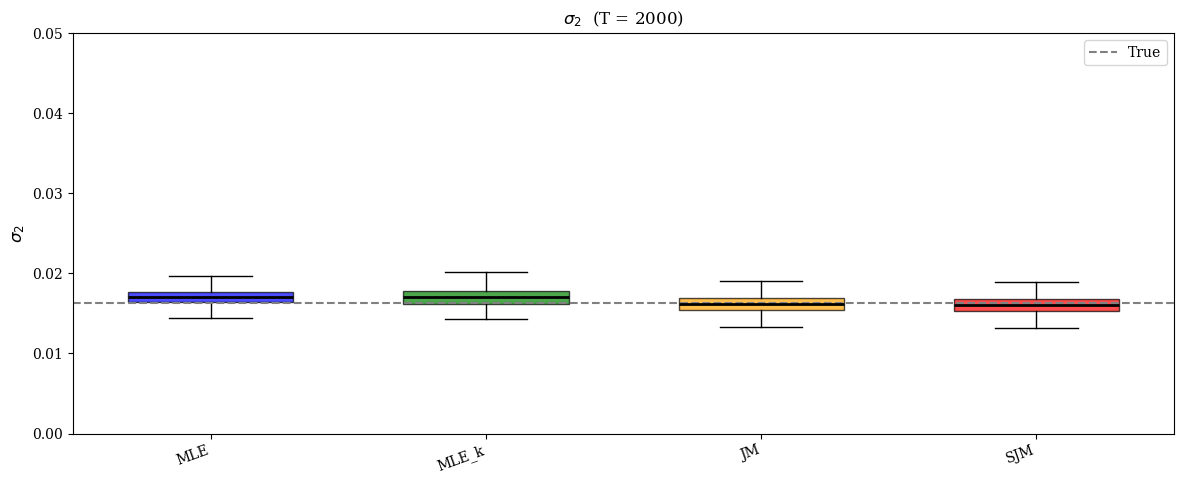

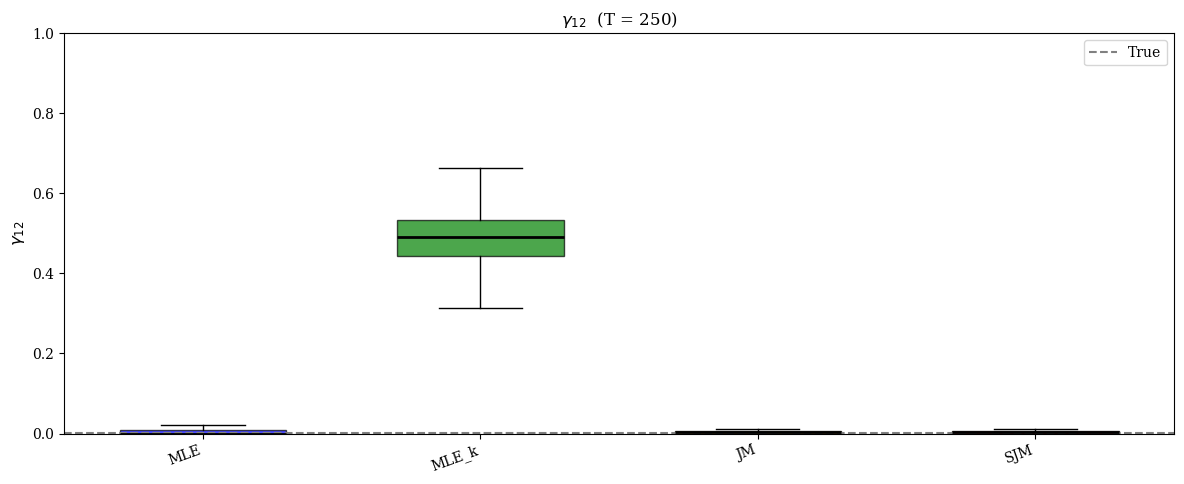

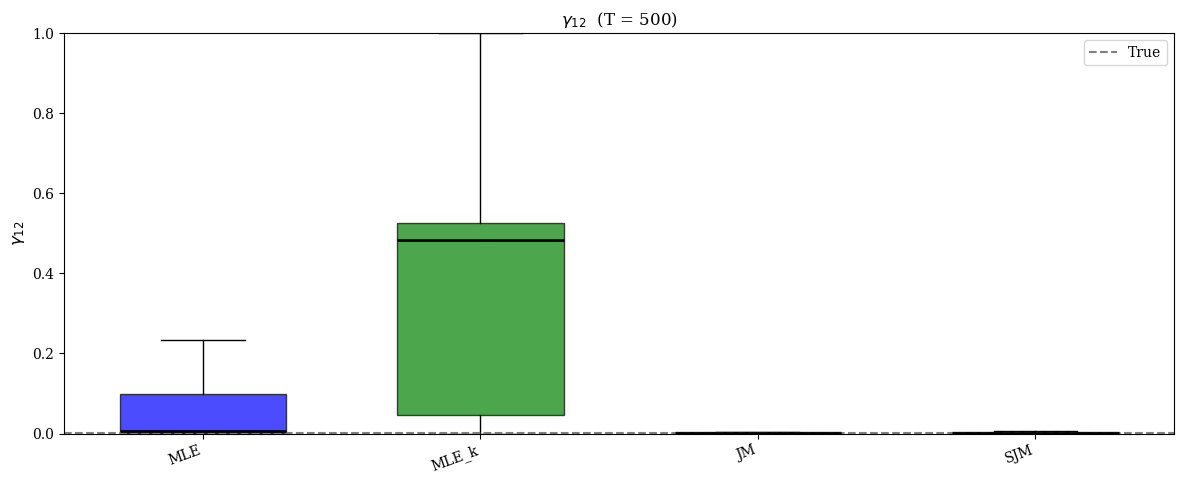

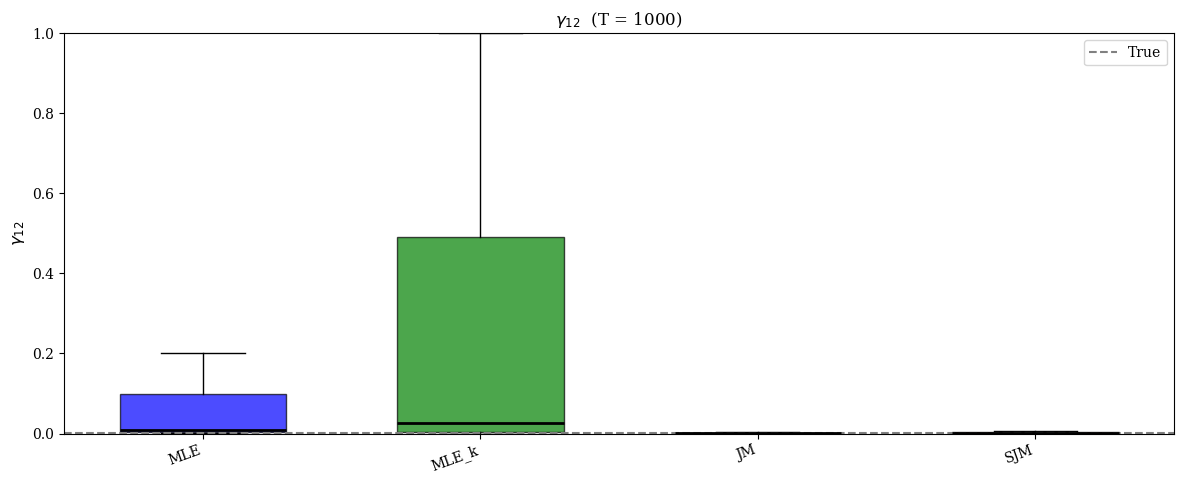

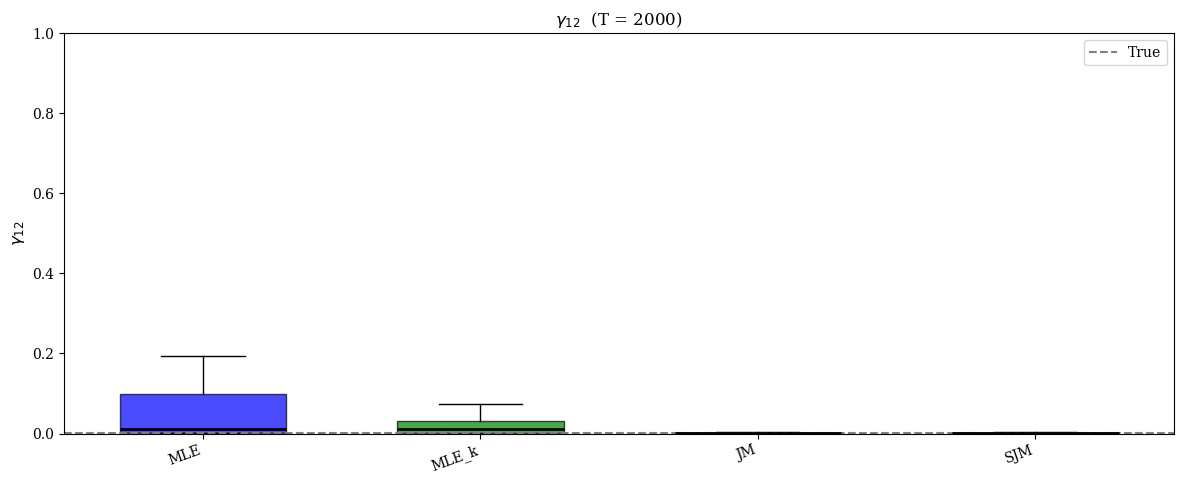

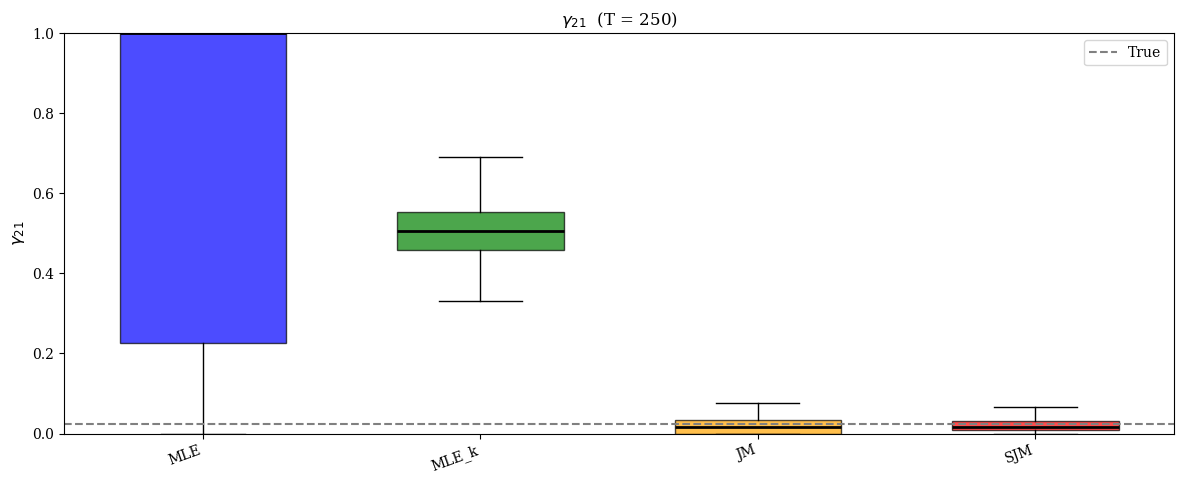

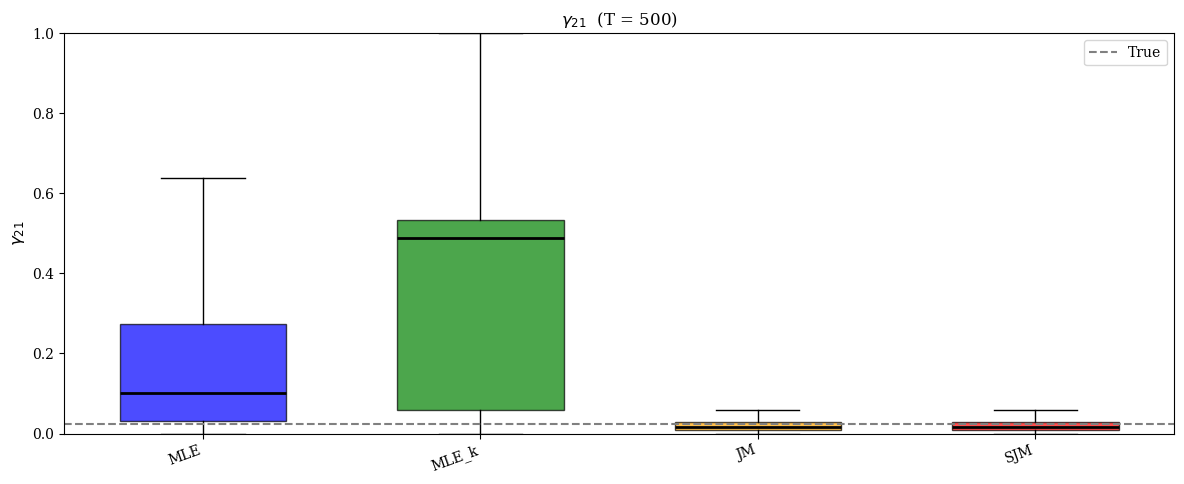

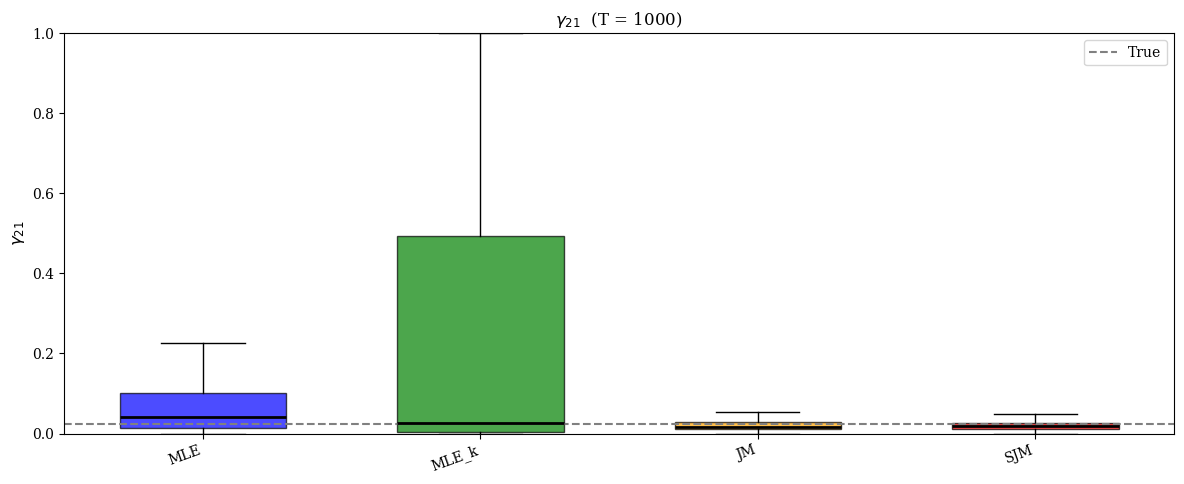

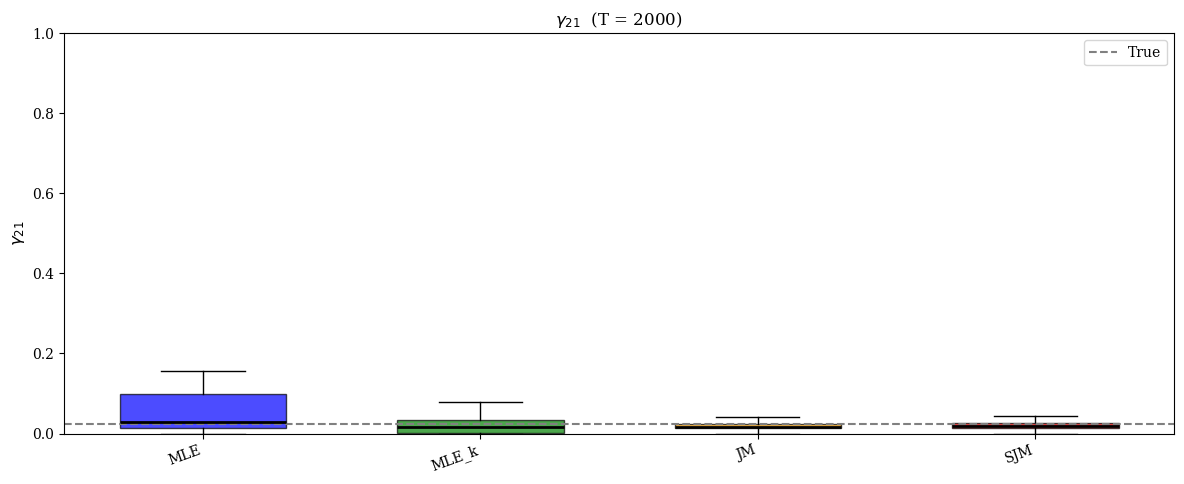

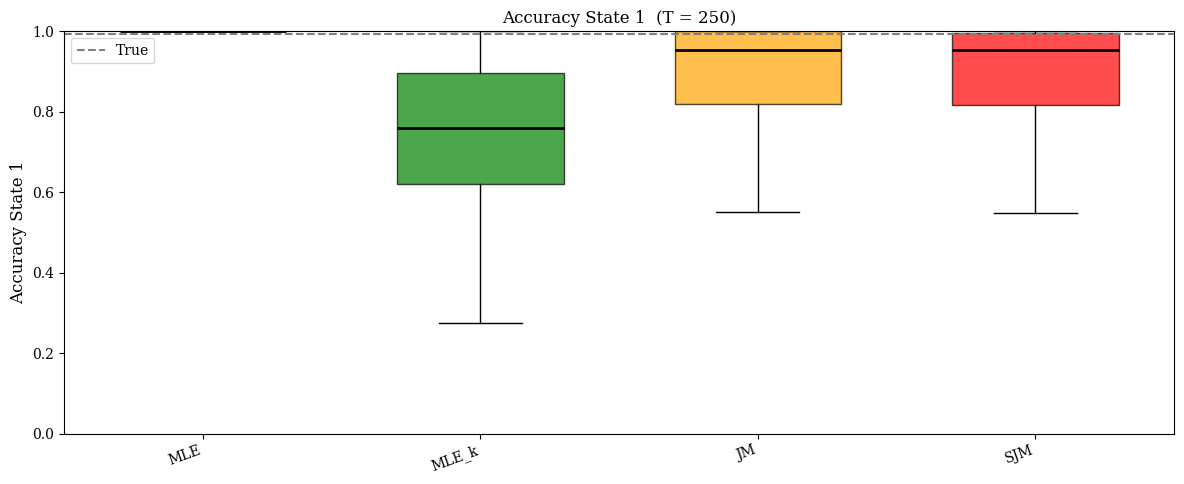

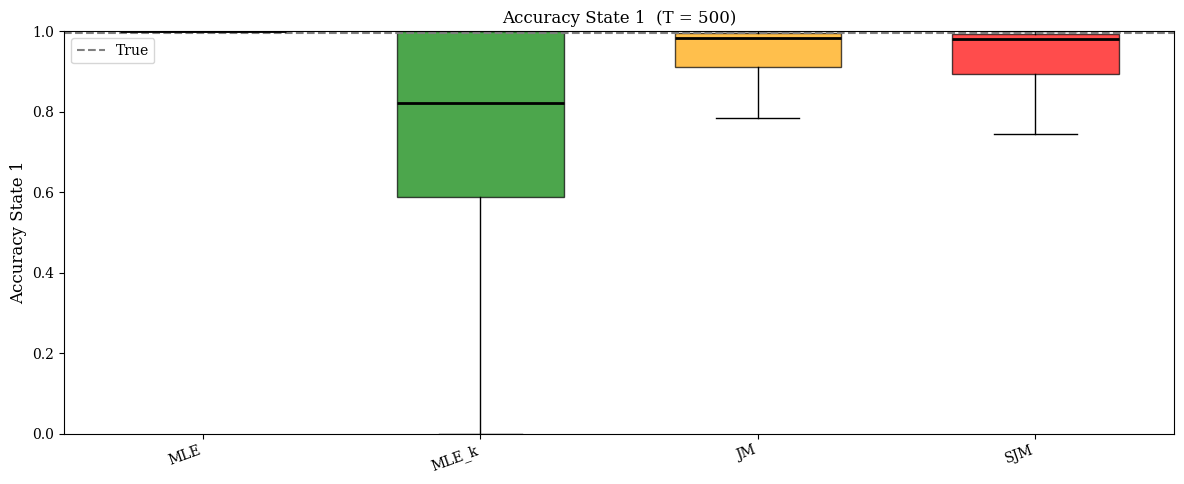

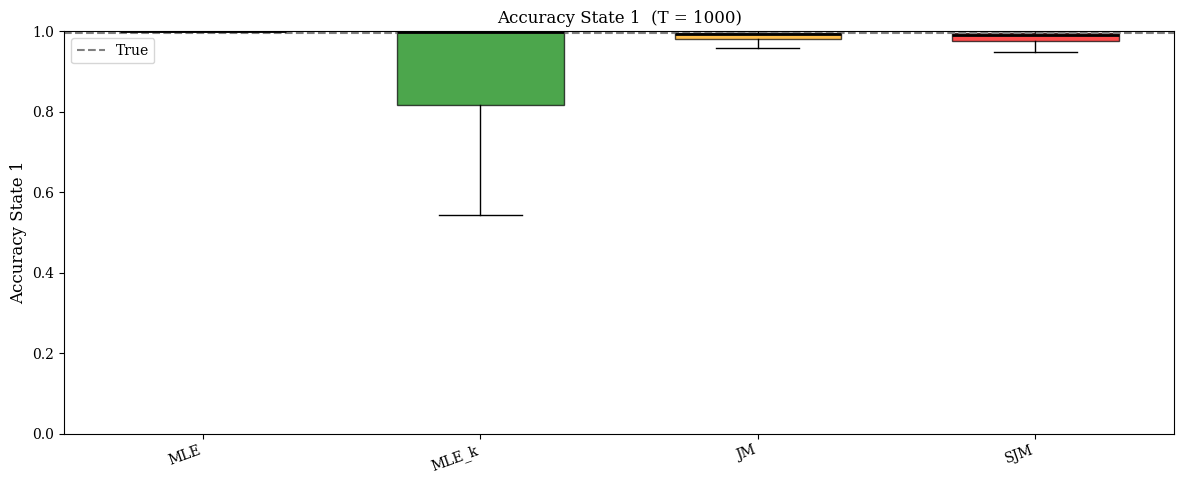

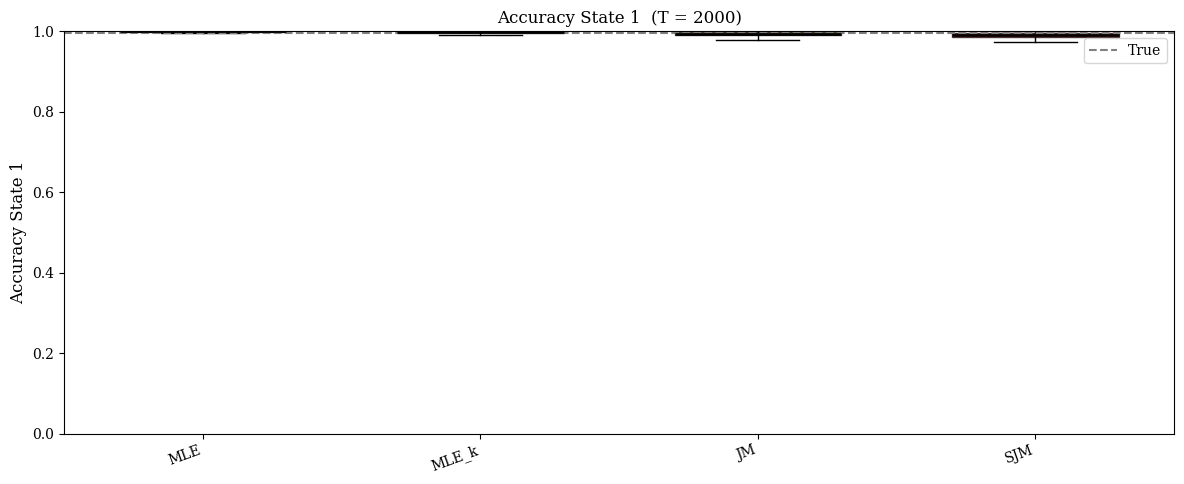

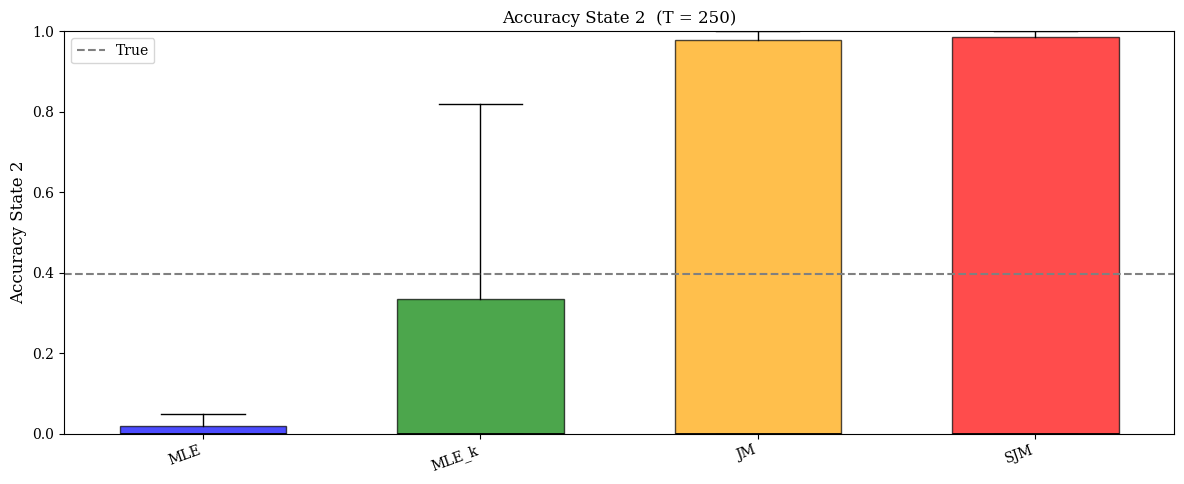

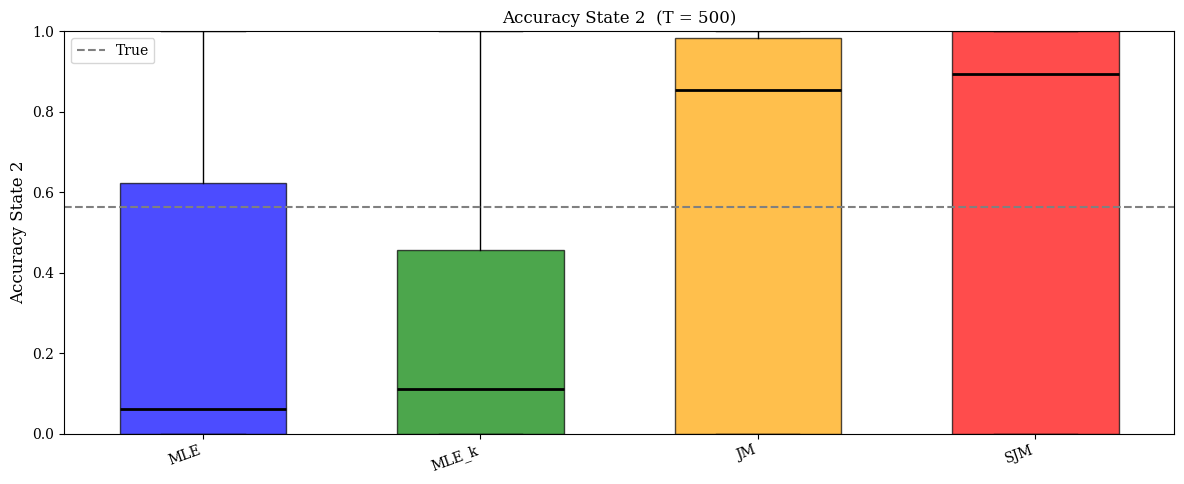

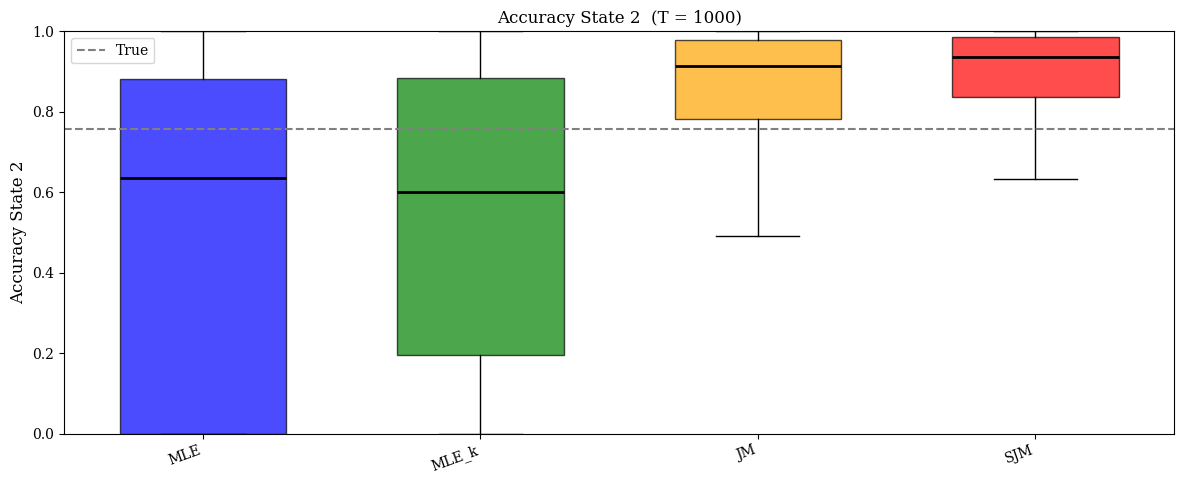

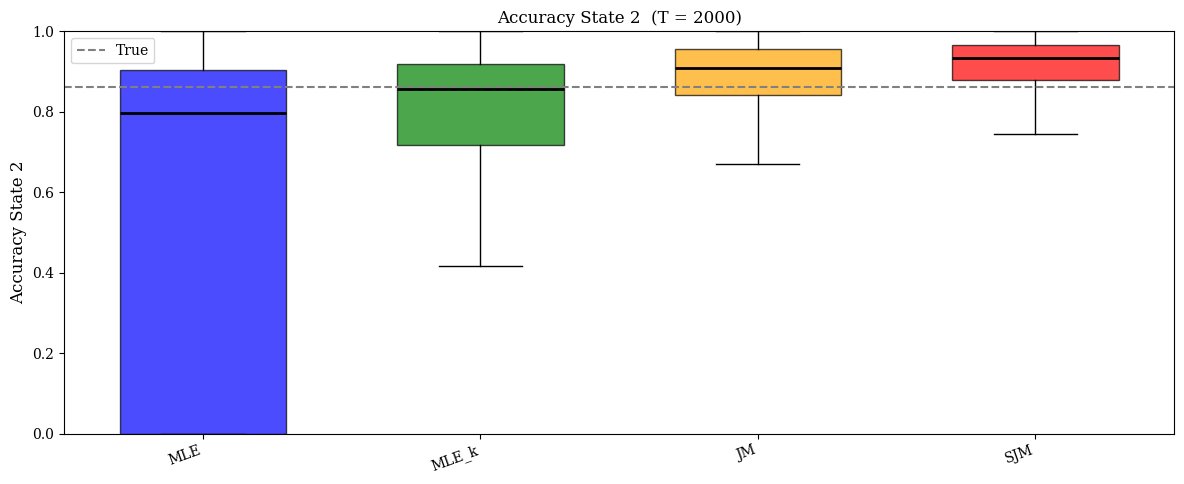

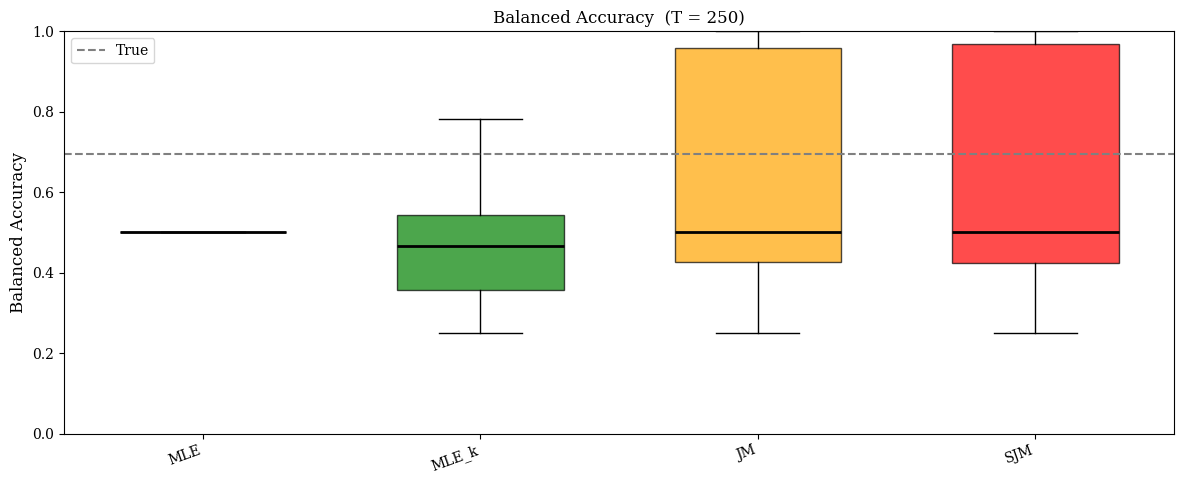

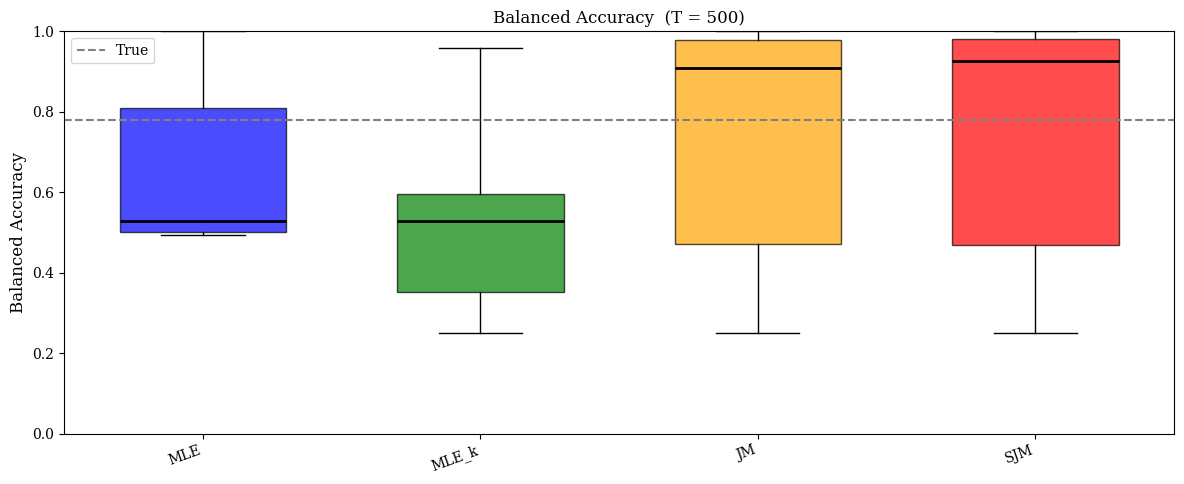

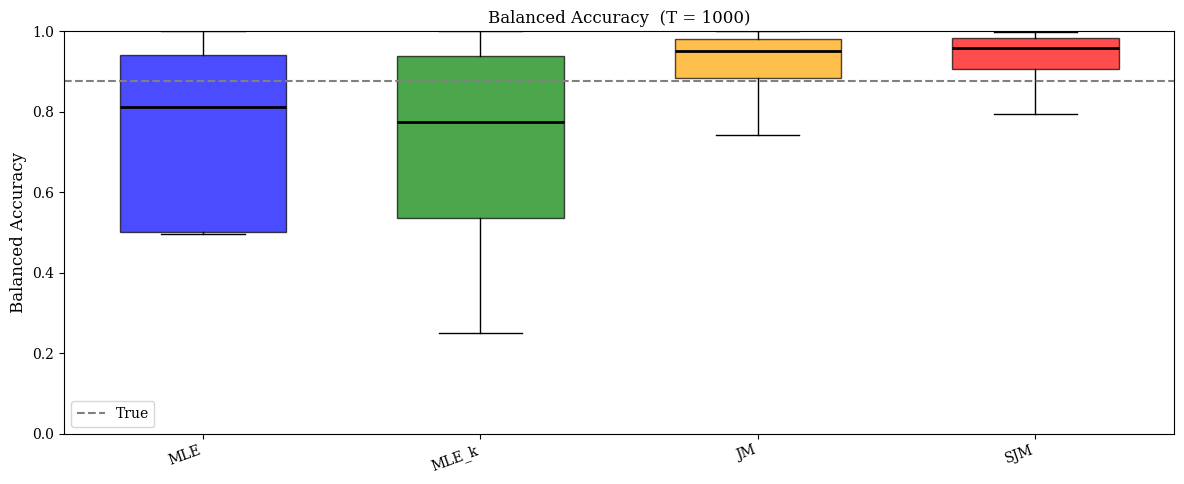

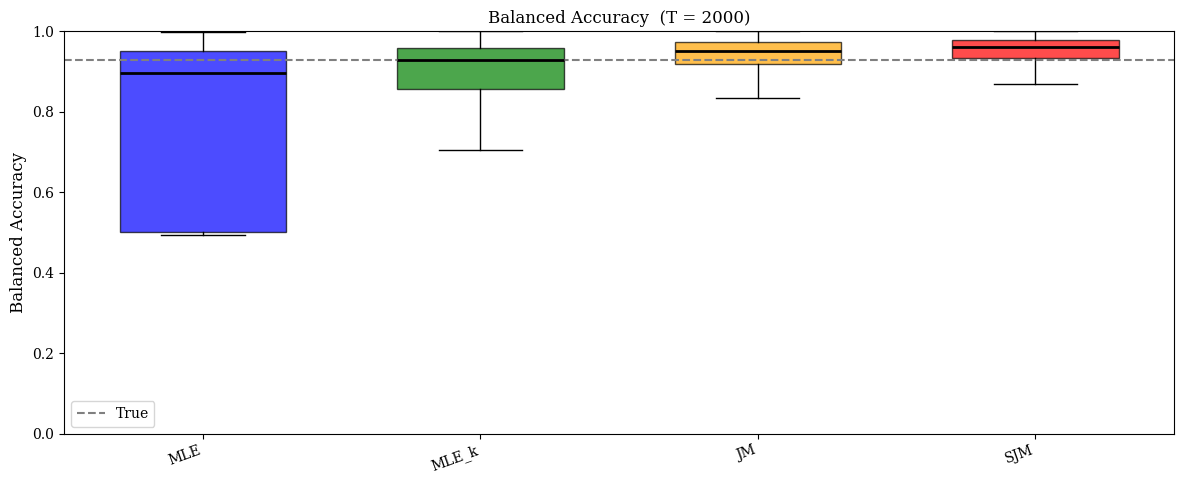

In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------------
# Journal-style matplotlib settings (no LaTeX).
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})
# ------------------------------------------------------------------------

###############################################################################
# 1) Hardcode the "true" parameter values for T=250, 500, 1000, and 2000.
#    (Add the values for T=500,1000,2000 as available.)
###############################################################################
true_values = {
    250: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
        "acc1":        0.9945,
        "acc2":        0.3959,
        "BAC":         0.6952
    },
    500: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9959,
         "acc2":        0.5635,
         "BAC":         0.7797
    },
    1000: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9963,
         "acc2":        0.7577,
         "BAC":         0.8770
    },
    2000: {
        "state0_mean": TRUE_MU0,
        "state1_mean": TRUE_MU1,
        "state0_vol":  TRUE_SIGMA0,
        "state1_vol":  TRUE_SIGMA1,
        "gamma12":     TRUE_GAMMA12,
        "gamma21":     TRUE_GAMMA21,
         "acc1":        0.9962,
         "acc2":        0.8616,
         "BAC":         0.9289
    }
}

###############################################################################
# 2) Define which parameters and method columns to plot.
###############################################################################
param_list = [
    "state0_mean", "state1_mean",
    "state0_vol",  "state1_vol",
    "gamma12",     "gamma21",
    "acc1",        "acc2",
    "BAC"
]
param_labels = {
    "state0_mean": r"$\mu_{1}$",
    "state1_mean": r"$\mu_{2}$",
    "state0_vol":  r"$\sigma_{1}$",
    "state1_vol":  r"$\sigma_{2}$",
    "gamma12":     r"$\gamma_{12}$",
    "gamma21":     r"$\gamma_{21}$",
    "acc1":        "Accuracy State 1",
    "acc2":        "Accuracy State 2",
    "BAC":         "Balanced Accuracy"
}

# List of methods. The "True" method is used only for the horizontal line.
methods = ["True", "MLE default", "MLE k-means", "Jump Model", "Sparse Jump"]
method_prefix = {
    "True": "True_",          # Make sure your final_results has columns like "True_state0_mean", etc.
    "MLE default": "MLE_",
    "MLE k-means": "MLEK_",
    "Jump Model": "Jump_",
    "Sparse Jump": "SparseJump_"
}

# Define simulation lengths to plot.
T_values = [250, 500, 1000, 2000]

###############################################################################
# Custom y limits per parameter (optional).
# To set custom limits, simply add an entry for the parameter, for example:
# custom_y_limits = {"state0_mean": (0.00055, 0.00065)}
###############################################################################
custom_y_limits = {
    "state0_mean": (-0.01, 0.015),
    "state1_mean": (-0.05, 0.05),
    "state0_vol":  (0.002, 0.012),
    "state1_vol":  (0., 0.05),
    "gamma12":     (0, 1),
    "gamma21":     (0, 1),
    "acc1":        (0, 1),
    "acc2":        (0, 1),
    "BAC":         (0, 1)
}

###############################################################################
# 3) Helper function: one wide boxplot for a single parameter & a single T.
###############################################################################
def plot_single_param_box(df, param, T_val, 
                          param_label="", 
                          y_limits=None, 
                          figsize=(10,5)):
    """
    Creates one wide boxplot for the given parameter (param) at the specified T_val.
    - df: the entire final_results DataFrame.
    - param: e.g. "state0_mean"
    - T_val: simulation length (e.g. 250)
    - param_label: a friendly name for the y-axis label/title.
    - y_limits: (ymin, ymax) to enforce a consistent scale across T.
    - figsize: ensures a wide layout (e.g., (10,5) or bigger)
    """
    df_T = df[df["T"] == T_val]
    
    # Only include methods for boxplot that are not "True".
    data_list = []
    method_labels = []
    for m in methods:
        if m == "True":
            continue  # Skip plotting box for "True"
        colname = method_prefix[m] + param
        values = df_T[colname].dropna().values
        data_list.append(values)
        method_labels.append(m)
    
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data_list, 
                     patch_artist=True, 
                     showfliers=False,
                     widths=0.6)
    
    # Define colors for the methods (adjust the order according to method_labels)
    box_colors = ["blue", "green", "orange", "red"]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(box_colors[i % len(box_colors)])
        box.set_alpha(0.7)
    for med in bp['medians']:
        med.set(color="black", linewidth=2.0)
    
    # Set x-tick labels for only the plotted methods.
    custom_labels = ["MLE", "MLE_k", "JM", "SJM"]  # Replace with your desired names
    plt.xticks(np.arange(1, len(custom_labels)+1), custom_labels, rotation=20, ha="right")
    plt.title(f"{param_label}  (T = {T_val})")
    plt.ylabel(param_label)
    
    # Draw a dashed horizontal line for the true value (if available).
    if T_val in true_values and param in true_values[T_val]:
        tv = true_values[T_val][param]
        plt.axhline(tv, color="gray", linestyle="--", linewidth=1.5, label="True")
        plt.legend(loc="best")
    
    if y_limits is not None:
        plt.ylim(y_limits)
    
    plt.tight_layout()
    plt.show()

###############################################################################
# 4) Main loop: For each parameter, compute a common y-limit (across all T values)
#    and then generate one wide boxplot for each T.
###############################################################################
for param in param_list:
    all_vals = []
    for T_val in T_values:
        # Include both "True" (for the horizontal line) and the other methods
        if T_val in true_values and param in true_values[T_val]:
            all_vals.append(true_values[T_val][param])
        for m in methods:
            if m == "True":
                continue
            colname = method_prefix[m] + param
            all_vals.extend(final_results[final_results["T"] == T_val][colname].dropna().values)
    
    if len(all_vals) == 0:
        continue
    
    # Compute common y-limit if no custom limit provided for this parameter.
    if param in custom_y_limits:
        y_limits = custom_y_limits[param]
    else:
        dmin, dmax = min(all_vals), max(all_vals)
        margin = 0.05 * (dmax - dmin) if (dmax > dmin) else 1e-6
        y_limits = (dmin - margin, dmax + margin)
    
    for T_val in T_values:
        plot_single_param_box(
            df=final_results,
            param=param,
            T_val=T_val,
            param_label=param_labels.get(param, param),
            y_limits=y_limits,
            figsize=(12,5)
        )

In [39]:
#MLE tables.
#Import the csv and then work with it in the ipynb to compute the MLE tables for all parameters over T.

#g_final_result_errors located in same folder holds all the data wee need.

# Read the CSV file created by your script
final_result_errors = pd.read_csv("g_final_result_errors.csv")
df = pd.read_csv("g_final_result_errors.csv")

# Define the metrics and the method prefixes (make sure these match your CSV column names)
metrics = ["state0_mean", "state1_mean", "state0_vol", "state1_vol",
           "gamma12", "gamma21", "acc1", "acc2", "BAC"]
methods = ["MLE", "MLEK", "Jump", "SparseJump"]

# Compute the squared error (MSE) for each method and each metric
for metric in metrics:
    true_col = f"True_{metric}"
    for method in methods:
        est_col = f"{method}_{metric}"
        mse_col = f"{method}_{metric}_MSE"
        df[mse_col] = (df[est_col] - df[true_col]) ** 2

# Group the results by the simulation length T
mse_tables = {}
for T_val in sorted(df["T"].unique()):
    df_T = df[df["T"] == T_val]
    mse_data = {}
    for method in methods:
        method_data = {}
        for metric in metrics:
            mse_col = f"{method}_{metric}_MSE"
            method_data[metric] = df_T[mse_col].mean()
        mse_data[method] = method_data
    mse_table = pd.DataFrame(mse_data).T  # Methods as rows, metrics as columns
    mse_tables[T_val] = mse_table
    print(f"--- MSE Table for T = {T_val} ---")
    print(mse_table.round(6), "\n")



--- MSE Table for T = 250 ---
            state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
MLE            0.000008     0.000387    0.000004    0.000127  0.018140  0.601764  0.028711  0.146691  0.034342
MLEK           0.000026     0.000208    0.000006    0.000146  0.246192  0.254612  0.093054  0.108034  0.069783
Jump           0.000000     0.000009    0.000000    0.000044  0.000009  0.000490  0.031353  0.215522  0.072622
SparseJump     0.000000     0.000008    0.000000    0.000043  0.000011  0.000441  0.032068  0.222706  0.075043 

--- MSE Table for T = 500 ---
            state0_mean  state1_mean  state0_vol  state1_vol   gamma12   gamma21      acc1      acc2       BAC
MLE            0.000000     0.000134    0.000000    0.000048  0.013647  0.197558  0.001016  0.201895  0.049916
MLEK           0.000013     0.000173    0.000005    0.000147  0.225240  0.212114  0.081462  0.177648  0.099550
Jump           0.000000     0.000008    0.000000  